In [112]:
import math
import matplotlib.pyplot as plt
# calculus
import sympy as sym
import random
import numpy as np

## Capture probability function

In [113]:
def P_cap(Px, Py, CR, gamma):
    # calculate power ratio threshold
    Pr = 10 ** (CR / 10)
    
    slope_1 = (Py * Pr / Px) ** (1 / gamma)
    slope_2 = (Py / (Px * Pr)) ** (1 / gamma)

    if slope_1 > 1 and slope_2 < 1:
        result = (1 / ((Pr * Py / Px) ** (1 / gamma)) / 2) + (((Py / (Pr * Px)) ** (1 / gamma)) / 2)
    elif slope_1 > 1 and slope_2 >= 1:
        result = 1 - (1 / ((Py / (Pr * Px)) ** (1 / gamma)) - 1 / ((Pr * Py / Px) ** (1 / gamma)) ) / 2
    elif slope_1 <= 1 and slope_2 < 1:
        result = 1 - (((Pr * Py / Px) ** (1 / gamma)) - ((Py / (Pr * Px)) ** (1 / gamma)) ) / 2
    return result

## Gereral analytical

In [120]:

# Lmax: Retransmit limit
# TXOP: in ms
# Imax: total slots in worst case
def analytical(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    counter_power=0
    # setting ocw_n [ocw_min, 1st_retry_ocw....]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
        
    Ri = [RA_RU for _ in range(0,Imax+1)]
    M  = [0 for _ in range(0,Imax+1)]
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    M_i_s_C = [0 for _ in range(0,Imax+1)] # total success packet
    
    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0

                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
                    
            M[i] += M_i[i][n]
            
        #/** statistics */  
        for n in range (1,Lmax+1) : # n=1;n<=Lmax;n++){
            M_i_s[i][n] = M_i[i][n] * math.exp(-M[i] / Ri[i])
            M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
            M_i_s_C[i] += M_i_s[i][n]
            
#             counter_power += M_i_s[i][n] * 1 * n
            counter_power += M_i[i][n] * 1


        #/** performance metric */  
        #/** success probability */
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
        counter_delay_slot += M_i_s_C[i] * i
    
    success_probability = success_packet / sta_amount
    access_delay = (TXOP * counter_delay_slot) / success_packet
    through_put = success_packet / Imax
#     Utilization
    utilization = success_packet / (Imax * RA_RU)
    counter_power = counter_power / success_packet
#     counter_power = counter_power / sta_amount
    
    
    return Imax,success_probability,access_delay, utilization, through_put, counter_power  # ,sta*success_probability

## Random analytical

In [132]:
# sta_amount: Total contend stations number
# RA_RU: RA_RU number reserved for UORA
# Lmax: Retransmit limit
# TXOP: Transaction Opportunity (time length in ms)
# ocw_min: minimum OCW
# ocw_max: maximum OCW
# CR: Capture Ratio (CR=infinite = no capture, CR=0 = always capture)

def analytical_random(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max, CR, step, gamma):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    counter_power=0
    # setting ocw for each transmission [ocw_min, 1st_retry_ocw...ocw_max]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax: Reserved slot for transmission (total slots in worst case)
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
    # Ri: RA_RU number i-th slot, (Ri[i])
    Ri = [RA_RU for _ in range(0,Imax+1)]
    # M: Arrival number for i-th slot, (M[i])
    M  = [0 for _ in range(0,Imax+1)]
    # M_i: Arrival number for i-th slot and n-th transmission (M_i[n])
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Fail stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot (M_i_s_C[i])
    M_i_s_C = [0 for _ in range(0,Imax+1)]
    
    
    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0
                    
                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
            M[i] += M_i[i][n]
            
        #/** statistics */  
        for n in range (1, Lmax+1):
#             Calculate capture probability
            capture_prob = 0
            if M[i] <= 0:
                M_i_s[i][n] = 0
                M_i_f[i][n] = 0
            else:
                for n1 in range(1, step+1):
                    for n2 in range(1, step+1):
                        # sta_ratio is M_i[n] / M_i
                        sta_ratio_1 = 1 / step
                        sta_ratio_2 = 1 / step
                        # P is the power of two station
                        P1 = 2 ** (n1 - 1)
                        P2 = 2 ** (n2 - 1)
                        capture_prob += P_cap(P1, P2, CR, gamma) * sta_ratio_1 * sta_ratio_2

                M_i_s[i][n] = M_i[i][n] * math.exp(-M[i] / Ri[i]) + capture_prob * M_i[i][n] * (M[i]) / (2 * Ri[i]) * math.exp(-M[i] / Ri[i])
#                 M_i_s[i][n] = M_i[i][n] * math.exp(-M[i] / Ri[i]) + capture_prob * M_i[i][n] * (M[i]-1) / (2 * Ri[i]) * math.exp(-M[i] / Ri[i])
                print(M_i[i][n] * (M[i]) / (2 * Ri[i]) * math.exp(-M[i] / Ri[i]))
                M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
                M_i_s_C[i] += M_i_s[i][n]
                
                avg_power = sum([2**n for n in range(step)]) / step
#                 counter_power += M_i_s[i][n] * avg_power * (n-1)
#                 # success STA have differnet power usage between captured and no-capture
#                 # capture power (avg power for captured power is 4.25)
#                 counter_power += 4.25 * capture_prob * M_i[i][n] * (M[i]-1) / (2 * Ri[i]) * math.exp(-M[i] / Ri[i])
#                 # no-capture power
#                 counter_power += avg_power * M_i[i][n] * math.exp(-M[i] / Ri[i])
                
                counter_power += avg_power * M_i[i][n]

        #/** performance metric */  
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
        counter_delay_slot += M_i_s_C[i] * i
    
    #/** success probability */
    success_probability = success_packet / sta_amount
        
    if success_packet != 0:
        access_delay = (TXOP * counter_delay_slot) / success_packet
#     Throughput 
    through_put = success_packet / Imax
#     Utilization
    utilization = success_packet / (Imax * RA_RU)
    # Average power usage
    if success_packet != 0:
        counter_power = counter_power / success_packet
#     counter_power = counter_power / sta_amount
    
    return Imax,success_probability,access_delay, utilization, through_put, counter_power  # ,sta*success_probability

## Transmit-based analytical

In [133]:
# sta_amount: Total contend stations number
# RA_RU: RA_RU number reserved for UORA
# Lmax: Retransmit limit
# TXOP: Transaction Opportunity (time length in ms)
# ocw_min: minimum OCW
# ocw_max: maximum OCW
# CR: Capture Ratio (CR=infinite = no capture, CR=0 = always capture)

def analytical_rampup(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max, CR, step, gamma):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    counter_power=0
    # setting ocw for each transmission [ocw_min, 1st_retry_ocw...ocw_max]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax: Reserved slot for transmission (total slots in worst case)
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
    # Ri: RA_RU number i-th slot, (Ri[i])
    Ri = [RA_RU for _ in range(0,Imax+1)]
    # M: Arrival number for i-th slot, (M[i])
    M  = [0 for _ in range(0,Imax+1)]
    # M_i: Arrival number for i-th slot and n-th transmission (M_i[n])
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Fail stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot (M_i_s_C[i])
    M_i_s_C = [0 for _ in range(0,Imax+1)]
    
    # set power for its n-th transmission
    power_n = [2 ** (x if x <= (step - 1) else (step - 1)) for x in range(Lmax)]

    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0
                    
                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
            M[i] += M_i[i][n]
            

        #/** statistics */  
        for n in range (1, Lmax+1):
            #/** Calculate capture probability for slot i */
            capture_prob = 0
            
            if M[i] > 0:
                for s in range(1, step+1):
                    # sta_ratio is M_i[n] / M_i
                    sta_ratio = 0
                    if (s == step):
                        for k in range(s, Lmax+1):
                            sta_ratio += M_i[i][k] / M[i]
                    else:
                        sta_ratio = M_i[i][s] / M[i]

                    # P is the power of two station
                    # calculate power by n-th transmission
                    P1 = 2 ** ((n-1) if (n-1) <= (step - 1) else (step - 1))
                    # calculate power by s-th step
                    P2 = 2 ** (s - 1)

                    capture_prob += P_cap(P1, P2, CR, gamma) * sta_ratio
            M_i_s[i][n] = M_i[i][n] * math.exp(-M[i] / Ri[i]) + capture_prob * M_i[i][n] * (M[i]) / (2 * Ri[i]) * math.exp(-M[i] / Ri[i])
#             M_i_s[i][n] = M_i[i][n] * math.exp(-M[i] / Ri[i]) + capture_prob * M_i[i][n] * (M[i]-1) / (2 * Ri[i]) * math.exp(-M[i] / Ri[i])
                
            M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
            M_i_s_C[i] += M_i_s[i][n]

#             counter_power += M_i_s[i][n] * (sum(power_n[:n]))
            counter_power += M_i[i][n] * power_n[n-1 if n <= step else step]

        #/** performance metric */  
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
        counter_delay_slot += M_i_s_C[i] * i
    
    #/** success probability */
    success_probability = success_packet / sta_amount
    
    if success_packet != 0:
        access_delay = (TXOP * counter_delay_slot) / success_packet
#     Throughput 
    through_put = success_packet / Imax
#     Utilization
    utilization = success_packet / (Imax * RA_RU)
    # Average power usage
    if success_packet != 0:
        counter_power = counter_power / success_packet
#     counter_power = counter_power / sta_amount

    return Imax,success_probability,access_delay, utilization, through_put, counter_power  # ,sta*success_probability

# Scenario I
Scenario III was designed to investigate the impact of transmit power levels $N$ on access success probability.

- Figure: $P_s$ for [$N=1$, $N=2$, $N=3$]
- Parameters: $R=128, C=3dB, L_{max}=5, OCW_{min}=7, OCW_{max}=31$
- x-axis: M STAs (10-200)

In [134]:
R = [9,18,37,74,148]
Lmax = 5
ocw_min = 7
ocw_max = 31
CR = 3
N = 4
T_slot = 5.673

# sta_max = 200

sta_max = 1000
m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_ramp  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

power_list = [ [0] * (sta_max) for _ in range(0, len(R))]
power_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
power_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

# General
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max)
        ps_list[idx][sta-1] = Ps
        da_list[idx][sta-1] = Da
        u_list[idx][sta-1] = U
        power_list[idx][sta-1] = power

# Random
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_random(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, step=N, gamma=2)
        ps_list_random[idx][sta-1] = Ps
        da_list_random[idx][sta-1] = Da
        u_list_random[idx][sta-1] = U
        power_list_random[idx][sta-1] = power

# RampUp
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_rampup(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, step=N, gamma=2)
        ps_list_ramp[idx][sta-1] = Ps
        da_list_ramp[idx][sta-1] = Da
        u_list_ramp[idx][sta-1] = U
        power_list_ramp[idx][sta-1] = power
        

0.0497132953785761
0.0
0.0
0.0
0.0
0.0
9.605610466909903e-05
0.0
0.0
0.0
0.0
3.469534840265096e-05
5.1254723202071435e-08
0.0
0.0
0.0
0.0
1.2054179711058358e-10
5.094434713463335e-14
0.0
0.0
0.0
1.137400061805852e-10
4.4653000059318825e-14
4.907448763540247e-20
0.0
0.0
3.983229844788724e-11
2.648639860942171e-14
5.1599194159089475e-20
0.0
0.0
1.5802159749467377e-12
2.3628999296647024e-15
1.2783405521074282e-20
0.0
0.0
0.0
2.8840925476208626e-22
1.3309862698161382e-25
0.0
0.0
0.0
5.5896464731565e-23
2.9597373143491757e-26
0.0
0.0
0.0
2.4581561467794347e-24
1.8018099298699612e-27
0.0
0.0
0.0
3.263146445128451e-27
4.879390648334393e-30
0.0
0.0
0.0
0.0
2.2985893082444543e-46
0.0
0.0
0.0
0.0
4.925013362104749e-48
0.0
0.0
0.0
0.0
7.931973513909321e-51
0.0
0.0
0.0
0.0
1.380900919080227e-56
0.177941645092624
0.0
0.0
0.0
0.0
0.0
0.001449616698413634
0.0
0.0
0.0
0.0
0.0005286527838689082
3.0467523575130263e-06
0.0
0.0
0.0
0.0
2.8180053245840224e-08
4.6637524957265154e-11
0.0
0.0
0.0
2.6582094955

0.0
0.0
0.024143795322669304
0.00715196839253524
0.0
0.0
0.0
0.00702729166845992
0.00313565161338299
0.0
0.0
0.0
0.0007378030145653202
0.000622724804708093
0.0
0.0
0.0
1.4916324888677567e-05
4.664322056763122e-05
0.0
0.0
0.0
0.0
2.533572994111888e-06
0.0
0.0
0.0
0.0
1.0634751358196835e-07
0.0
0.0
0.0
0.0
7.980967119983538e-10
0.0
0.0
0.0
0.0
2.9208034521410615e-13
2.0895159353234303
0.0
0.0
0.0
0.0
0.0
2.3216131500476385
0.0
0.0
0.0
0.0
1.5271827259299067
0.5339551153436554
0.0
0.0
0.0
0.0
0.6727181179455274
0.08664236631954848
0.0
0.0
0.0
0.6617196747620077
0.1428091551153964
0.008136246617693679
0.0
0.0
0.3738627667511404
0.1776476446881348
0.018665993807894687
0.0
0.0
0.05585948498890907
0.10041116928282458
0.019401876380615763
0.0
0.0
0.0
0.034387450128490184
0.010957232027455778
0.0
0.0
0.0
0.010327163785588624
0.0050135295901119386
0.0
0.0
0.0
0.0011451353513004493
0.0010643667075504687
0.0
0.0
0.0
2.5817816315128338e-05
8.961420995605619e-05
0.0
0.0
0.0
0.0
5.431208601260629e-06

0.0
0.0
0.0
0.4818397935949059
0.6282569608441227
0.0
0.0
0.0
0.12811708221378157
0.36958969807485376
0.0
0.0
0.0
0.010411874249524167
0.11915200723530654
0.0
0.0
0.0
0.0
0.022199077806865836
0.0
0.0
0.0
0.0
0.002042637327297141
0.0
0.0
0.0
0.0
5.431523893825247e-05
0.0
0.0
0.0
0.0
1.9088841379850569e-07
0.6621264185508168
0.0
0.0
0.0
0.0
0.0
1.870785797757721
0.0
0.0
0.0
0.0
1.439331278096947
0.6818559829495824
0.0
0.0
0.0
0.0
1.9619096594068985
0.3637319154965212
0.0
0.0
0.0
1.6908779379467633
0.6637267604432996
0.06861546105320261
0.0
0.0
1.1344929644404527
1.049201974638212
0.2210952467457186
0.0
0.0
0.3329087323175282
1.2769869553564672
0.5135851162721046
0.0
0.0
0.0
0.9755200659796767
0.720405988037171
0.0
0.0
0.0
0.5170379712675992
0.6911145213149389
0.0
0.0
0.0
0.14179257300612383
0.42093712223728286
0.0
0.0
0.0
0.011962452704262423
0.141086424823569
0.0
0.0
0.0
0.0
0.027131964230021954
0.0
0.0
0.0
0.0
0.0025630095802136876
0.0
0.0
0.0
0.0
7.049175607442559e-05
0.0
0.0
0.0
0.0


0.0
0.0
0.0
1.2732505282527677
1.156315781885251
0.0
0.0
0.0
0.8636359025795508
1.5021976107850032
0.0
0.0
0.0
0.35939026877324765
1.4473665385176153
0.0
0.0
0.0
0.04969378732724818
0.8098535595151154
0.0
0.0
0.0
0.0
0.23773408072062124
0.0
0.0
0.0
0.0
0.031985429318927026
0.0
0.0
0.0
0.0
0.0013244494894526725
0.0
0.0
0.0
0.0
8.099412415742197e-06
0.1581208591279061
0.0
0.0
0.0
0.0
0.0
0.972455349324537
0.0
0.0
0.0
0.0
0.8193559742522939
0.4145298013388899
0.0
0.0
0.0
0.0
1.9280378829316112
0.38699409580595706
0.0
0.0
0.0
1.3254452994890895
0.6102005941964831
0.07243364997969454
0.0
0.0
0.8333764795309191
0.9119194750727276
0.22751500305363753
0.0
0.0
0.2908029838018516
1.342014843255506
0.6419017756615818
0.0
0.0
0.0
1.2648781707415648
1.155888835506936
0.0
0.0
0.0
0.8667806192861472
1.5198162401787498
0.0
0.0
0.0
0.36717139135585175
1.492574606817929
0.0
0.0
0.0
0.05183047918826422
0.8531787066869194
0.0
0.0
0.0
0.0
0.2549473932737327
0.0
0.0
0.0
0.0
0.034809421943620605
0.0
0.0
0.0


0.0
0.0
1.3528784457721994
0.2794170115858264
0.0
0.0
0.0
0.686064096013438
0.3408470938098394
0.042963493920721636
0.0
0.0
0.38556708794280814
0.45435810393213016
0.12204666378058007
0.0
0.0
0.15389328057440985
0.7673521796148249
0.39331578249329
0.0
0.0
0.0
0.8372042798163732
0.8321214203885503
0.0
0.0
0.0
0.7112988652407637
1.3919834684767551
0.0
0.0
0.0
0.43310639681634455
2.0021378812591744
0.0
0.0
0.0
0.09198723402940742
1.741705667748009
0.0
0.0
0.0
0.0
0.7370646839420409
0.0
0.0
0.0
0.0
0.13307114387816985
0.0
0.0
0.0
0.0
0.007338832419871198
0.0
0.0
0.0
0.0
6.159324448039051e-05
0.01709418680797932
0.0
0.0
0.0
0.0
0.0
0.3088498390329463
0.0
0.0
0.0
0.0
0.2985821370671426
0.15460334280853258
0.0
0.0
0.0
0.0
1.3286575302913042
0.27454911269833404
0.0
0.0
0.0
0.6658421205745533
0.33136539301911894
0.04182111257922649
0.0
0.0
0.37264868551432684
0.43982474121739545
0.1183270565413137
0.0
0.0
0.14950473010275095
0.7466612155645067
0.38323360465804374
0.0
0.0
0.0
0.8189506693464693


0.0
0.0
0.12376490450590781
0.06435258258384143
0.0
0.0
0.0
0.0
0.8887516308127544
0.18468637236508087
0.0
0.0
0.0
0.3533393313846905
0.18001105499428785
0.023103094469814706
0.0
0.0
0.18310337386454176
0.2206740886762187
0.060609439476804694
0.0
0.0
0.081584564354731
0.41611809983960224
0.21735062469081595
0.0
0.0
0.0
0.5068596977874482
0.5155202292384827
0.0
0.0
0.0
0.5038628925840067
1.017632851394987
0.0
0.0
0.0
0.3924087195723244
1.8837577921583306
0.0
0.0
0.0
0.10811583910126986
2.1374649522815665
0.0
0.0
0.0
0.0
1.121498308879037
0.0
0.0
0.0
0.0
0.2383230894176468
0.0
0.0
0.0
0.0
0.015137733083797459
0.0
0.0
0.0
0.0
0.00014703441820694356
0.0025007823000755113
0.0
0.0
0.0
0.0
0.0
0.10831573606935144
0.0
0.0
0.0
0.0
0.11822673577624497
0.06147926148677639
0.0
0.0
0.0
0.0
0.8695359997780382
0.1807194531992175
0.0
0.0
0.0
0.341808592137584
0.17427149963254898
0.02237839279331287
0.0
0.0
0.17649703070689166
0.2128537453657545
0.0584999133086808
0.0
0.0
0.07906397266687064
0.40352934

0.0
1.5228200525134565
0.0
0.0
0.0
0.0
0.3808647067669438
0.0
0.0
0.0
0.0
0.027529937458970945
0.0
0.0
0.0
0.0
0.00030384430724274606
0.0002105329603047396
0.0
0.0
0.0
0.0
0.0
0.026938508971040602
0.0
0.0
0.0
0.0
0.034349739973521386
0.017885046542269804
0.0
0.0
0.0
0.0
0.4709499906688731
0.09806380364578503
0.0
0.0
0.0
0.13885383068581408
0.07170887247884095
0.009287536746122857
0.0
0.0
0.0657775211244928
0.0801777219187605
0.022268094428715492
0.0
0.0
0.034000428631590994
0.1753738879988274
0.09240451316123133
0.0
0.0
0.0
0.24640497781796317
0.253352449494345
0.0
0.0
0.0
0.2974276844904499
0.6102192623699472
0.0
0.0
0.0
0.30961216812421827
1.5154613415264921
0.0
0.0
0.0
0.11439171342626137
2.3166817846762244
0.0
0.0
0.0
0.0
1.5365740566839317
0.0
0.0
0.0
0.0
0.38651595446342585
0.0
0.0
0.0
0.0
0.02805981067834425
0.0
0.0
0.0
0.0
0.0003109881202132492
0.00019111361415939142
0.0
0.0
0.0
0.0
0.0
0.02549413433783781
0.0
0.0
0.0
0.0
0.032704688408129054
0.017028829767839596
0.0
0.0
0.0
0.

0.07232546597151264
0.038214957573859946
0.0
0.0
0.0
0.11681820935874172
0.12054374170894827
0.0
0.0
0.0
0.1695360051509325
0.34975493948778225
0.0
0.0
0.0
0.23101554753601558
1.1388889573537198
0.0
0.0
0.0
0.11122507964726466
2.2753387446417537
0.0
0.0
0.0
0.0
1.8524052416250005
0.0
0.0
0.0
0.0
0.5361662092322488
0.0
0.0
0.0
0.0
0.043081883644821885
0.0
0.0
0.0
0.0
0.0005251836336318998
1.4949381568667429e-05
0.0
0.0
0.0
0.0
0.0
0.0058918781550544325
0.0
0.0
0.0
0.0
0.00884664136413451
0.004607377795600661
0.0
0.0
0.0
0.0
0.23190104372714118
0.04830770590388843
0.0
0.0
0.0
0.05121302074675031
0.02658647075086284
0.003454847007877693
0.0
0.0
0.02237017174692492
0.027378187196485375
0.007634035744071766
0.0
0.0
0.01348717291047058
0.06984269949336437
0.03690532909976883
0.0
0.0
0.0
0.11341715341483156
0.1170433317877339
0.0
0.0
0.0
0.1657668896204675
0.34202150999608905
0.0
0.0
0.0
0.22821138188296075
1.125251405839755
0.0
0.0
0.0
0.11098044026775213
2.270910345195791
0.0
0.0
0.0
0.0
1.

0.0
0.0
0.0
0.0
0.002278109028253975
0.001186503281824697
0.0
0.0
0.0
0.0
0.11152826961928444
0.02323454954328758
0.0
0.0
0.0
0.018743541165292296
0.009749609406916656
0.0012684813304533573
0.0
0.0
0.00759934028572507
0.009314046038472327
0.002600754758426765
0.0
0.0
0.0053271948888327205
0.02762521970586789
0.01461121705718278
0.0
0.0
0.0
0.05161837450718413
0.053335373979467096
0.0
0.0
0.0
0.0906257273800964
0.18736492531308901
0.0
0.0
0.0
0.16278739045736804
0.8049110202764683
0.0
0.0
0.0
0.10246073423144271
2.1062541341377163
0.0
0.0
0.0
0.0
2.100011610809583
0.0
0.0
0.0
0.0
0.6946228467235906
0.0
0.0
0.0
0.0
0.060992875564468634
0.0
0.0
0.0
0.0
0.0008040171374480763
1.0060932220454179e-06
0.0
0.0
0.0
0.0
0.0
0.0012213770041481337
0.0
0.0
0.0
0.0
0.0021605549224123434
0.0011252785032984456
0.0
0.0
0.0
0.0
0.10834574389558381
0.022571566553237814
0.0
0.0
0.0
0.01801955762883413
0.009373449067451498
0.001219574567873552
0.0
0.0
0.007285171725733718
0.008929277758647266
0.002493394793

0.0
0.0
2.2680774703509785
0.0
0.0
0.0
0.0
0.8473293006722625
0.0
0.0
0.0
0.0
0.08019818189066469
0.0
0.0
0.0
0.0
0.0011237518814694685
7.207478102390196e-08
0.0
0.0
0.0
0.0
0.0
0.00025851188549563
0.0
0.0
0.0
0.0
0.0005355453441216112
0.00027892938972204394
0.0
0.0
0.0
0.0
0.05016529774438475
0.010451059005776298
0.0
0.0
0.0
0.006366335741232626
0.003314163895364877
0.00043140323772305924
0.0
0.0
0.002392610232095055
0.0029341247881401896
0.0008197427304307621
0.0
0.0
0.001963768812331415
0.010189005707756061
0.005390943131604193
0.0
0.0
0.0
0.022032268712565414
0.0227758189001526
0.0
0.0
0.0
0.04677907765078317
0.09679064681695489
0.0
0.0
0.0
0.11066249952386148
0.5478177494229866
0.0
0.0
0.0
0.09082178148652519
1.8713210125025737
0.0
0.0
0.0
0.0
2.2732619043879665
0.0
0.0
0.0
0.0
0.8531737887452522
0.0
0.0
0.0
0.0
0.0809722193716439
0.0
0.0
0.0
0.0
0.0011370047702310504
6.50856911668049e-08
0.0
0.0
0.0
0.0
0.0
0.00024337631329711293
0.0
0.0
0.0
0.0
0.0005072625379881771
0.0002641988

0.0
0.0007314441115423786
0.0037958249319035397
0.0020085916188272834
0.0
0.0
0.0
0.009448183134506136
0.009768636915055761
0.0
0.0
0.0
0.024086401040767525
0.049851453318152196
0.0
0.0
0.0
0.0742680522171549
0.3678197468379231
0.0
0.0
0.0
0.07863945361093823
1.622106162004543
0.0
0.0
0.0
0.0
2.3774604592605773
0.0
0.0
0.0
0.0
1.0037085888454935
0.0
0.0
0.0
0.0
0.10195373182049837
0.0
0.0
0.0
0.0
0.0015051513558973538
4.527744069643557e-09
0.0
0.0
0.0
0.0
0.0
5.002191854857731e-05
0.0
0.0
0.0
0.0
0.0001221025881708825
6.359507956976427e-05
0.0
0.0
0.0
0.0
0.021885173694777063
0.004559407390692262
0.0
0.0
0.0
0.00210012155468244
0.0010936093636624202
0.0001423810738137746
0.0
0.0
0.0007320749608905074
0.000897949532356985
0.00025092185844061463
0.0
0.0
0.000703859667918693
0.0036526913374088834
0.0019328564584579072
0.0
0.0
0.0
0.009141254480952996
0.00945133218735351
0.0
0.0
0.0
0.023468419997839253
0.04857273369408824
0.0
0.0
0.0
0.07310384943971206
0.362057785367541
0.0
0.0
0.0
0.078

1.005275559315356e-05
0.0
0.0
0.0
0.0
2.8738337566266892e-05
1.4967883370338124e-05
0.0
0.0
0.0
0.0
0.009622149684736313
0.0020046141743331916
0.0
0.0
0.0
0.0007058759700745637
0.00036761704851631774
4.786471522073312e-05
0.0
0.0
0.0002289165739569855
0.0002808056822228712
7.847367751036188e-05
0.0
0.0
0.0002563645225443751
0.0013305014212437723
0.0007040778488499157
0.0
0.0
0.0
0.003832877633560119
0.003963122345782185
0.0
0.0
0.0
0.011814336204871798
0.024454767060559053
0.0
0.0
0.0
0.04796898206372403
0.23761661143976912
0.0
0.0
0.0
0.06616558454189327
1.3656058090289327
0.0
0.0
0.0
0.0
2.4290584894730882
0.0
0.0
0.0
0.0
1.15594150888666
0.0
0.0
0.0
0.0
0.12537904502203806
0.0
0.0
0.0
0.0
0.0019330374479466852
2.7762176092759243e-10
0.0
0.0
0.0
0.0
0.0
9.44742104177361e-06
0.0
0.0
0.0
0.0
2.7172445311682945e-05
1.415231457735242e-05
0.0
0.0
0.0
0.0
0.009319167594015137
0.0019414929358914743
0.0
0.0
0.0
0.0006766283280311425
0.00035238592171092767
4.5881653712129475e-05
0.0
0.0
0.000

0.0
0.0
6.935684098950783e-05
0.0003599647114248235
0.0001904904509119949
0.0
0.0
0.0
0.0012397507023654533
0.001281910168399234
0.0
0.0
0.0
0.0048193543808859405
0.009976144291948636
0.0
0.0
0.0
0.02739400421348852
0.13570916254514656
0.0
0.0
0.0
0.05220441765460725
1.0778294091159832
0.0
0.0
0.0
0.0
2.426624354315387
0.0
0.0
0.0
0.0
1.3341156420706848
0.0
0.0
0.0
0.0
0.1560730401985124
0.0
0.0
0.0
0.0
0.0025143704388126643
8.915751660881551e-12
0.0
0.0
0.0
0.0
0.0
1.1999762266609895e-06
0.0
0.0
0.0
0.0
4.217674722229393e-06
2.1967055725297335e-06
0.0
0.0
0.0
0.0
0.0031972288601091084
0.0006660893315207105
0.0
0.0
0.0
0.00016514466460243476
8.601104294970175e-05
1.119921358404094e-05
0.0
0.0
4.87364444796059e-05
5.9785622377061866e-05
1.6708167864913874e-05
0.0
0.0
6.663702014887117e-05
0.00034584889402128647
0.0001830205231277073
0.0
0.0
0.0
0.0011975982954524284
0.0012383247640047944
0.0
0.0
0.0
0.004688340747207601
0.009704950487993132
0.0
0.0
0.0
0.026922417222545594
0.13337311874

0.0
0.0
2.3220049541604826e-07
0.0
0.0
0.0
0.0
9.558198972117744e-07
4.978228626516454e-07
0.0
0.0
0.0
0.0
0.0013535165774139454
0.00028198261905714
0.0
0.0
0.0
5.346754081271575e-05
2.7847452909622854e-05
3.625952878245722e-06
0.0
0.0
1.4681547655801577e-05
1.8010187600572255e-05
5.033310603039924e-06
0.0
0.0
2.338472357772042e-05
0.00012136859493124321
6.422759467985558e-05
0.0
0.0
0.0
0.00048376944298376745
0.0005002238627586275
0.0
0.0
0.0
0.002273713931273745
0.004706681363674167
0.0
0.0
0.0
0.0170204740350275
0.08432108335804657
0.0
0.0
0.0
0.042259474755268665
0.8726213586268394
0.0
0.0
0.0
0.0
2.381396326263587
0.0
0.0
0.0
0.0
1.4719711503494932
0.0
0.0
0.0
0.0
0.18273662761235118
0.0
0.0
0.0
0.0
0.003034783309037889
5.256783989839631e-13
0.0
0.0
0.0
0.0
0.0
2.1792954021438022e-07
0.0
0.0
0.0
0.0
9.025431398303534e-07
4.700745515714457e-07
0.0
0.0
0.0
0.0
0.0013091621468454063
0.0002727421128003188
0.0
0.0
0.0
5.118481171695449e-05
2.665854886870144e-05
3.4711490216809623e-06
0

0.7031981589221812
0.0
0.0
0.0
0.0
2.3092069438528493
0.0
0.0
0.0
0.0
1.5970181868526956
0.0
0.0
0.0
0.0
0.20963078253426654
0.0
0.0
0.0
0.0
0.003572260128421831
3.399320069647642e-14
0.0
0.0
0.0
0.0
0.0
4.1636452349557635e-08
0.0
0.0
0.0
0.0
2.0194731306718872e-07
1.0518089220582208e-07
0.0
0.0
0.0
0.0
0.0005472055131601499
0.0001140011484793692
0.0
0.0
0.0
1.63625690674428e-05
8.522146013477575e-06
1.109652445999062e-06
0.0
0.0
4.168941606943741e-06
5.114151215891862e-06
1.4292572099362148e-06
0.0
0.0
7.781067328141476e-06
4.038448241198474e-05
2.1371283131515692e-05
0.0
0.0
0.0
0.00018629536758010977
0.00019263225718317217
0.0
0.0
0.0
0.0010586204147755992
0.0021913971511057233
0.0
0.0
0.0
0.010436517816941457
0.051704044072244854
0.0
0.0
0.0
0.033763198855776305
0.697230802393439
0.0
0.0
0.0
0.0
2.3059622299915175
0.0
0.0
0.0
0.0
1.6016672486708725
0.0
0.0
0.0
0.0
0.21068789518125736
0.0
0.0
0.0
0.0
0.003593628995430595
3.058815063809944e-14
0.0
0.0
0.0
0.0
0.0
3.905984212021131e-0

1.5052962863343634e-06
4.2068719599686914e-07
0.0
0.0
2.6680357196830497e-06
1.3847374542176e-05
7.327971636787419e-06
0.0
0.0
0.0
7.352907716518077e-05
7.603025016295969e-05
0.0
0.0
0.0
0.0005016304452374054
0.0010384016497912683
0.0
0.0
0.0
0.0064469636570458864
0.031939332424483255
0.0
0.0
0.0
0.026912012078970902
0.5557703824264616
0.0
0.0
0.0
0.0
2.2115987021183927
0.0
0.0
0.0
0.0
1.7181783259532044
0.0
0.0
0.0
0.0
0.23873582001439486
0.0
0.0
0.0
0.0
0.004167060269652557
1.9565652002494728e-15
0.0
0.0
0.0
0.0
0.0
7.381715055317253e-09
0.0
0.0
0.0
0.0
4.218645921887903e-08
2.1972114175928998e-08
0.0
0.0
0.0
0.0
0.00021873100283259346
4.5568958916164844e-05
0.0
0.0
0.0
4.951005847335038e-06
2.578646055370126e-06
3.3576098452390444e-07
0.0
0.0
1.1704751588645987e-06
1.4358545547307688e-06
4.01280230896823e-07
0.0
0.0
2.559942907286498e-06
1.3286362249921784e-05
7.031086416013971e-06
0.0
0.0
0.0
7.093293208034497e-05
7.334579562424935e-05
0.0
0.0
0.0
0.00048733320482108967
0.001008805

0.0
0.0
0.0
1.3824017820240458e-09
0.0
0.0
0.0
0.0
9.25257427787143e-09
4.819049103036206e-09
0.0
0.0
0.0
0.0
8.961625170363525e-05
1.86700524376529e-05
0.0
0.0
0.0
1.551434179931206e-06
8.080382988926428e-07
1.0521329387888345e-07
0.0
0.0
3.41272347831963e-07
4.1864848763534784e-07
1.170003108972141e-07
0.0
0.0
8.695095948185102e-07
4.512844331506356e-06
2.3881785605820404e-06
0.0
0.0
0.0
2.773293264698757e-05
2.8676307802158942e-05
0.0
0.0
0.0
0.00022874944226454407
0.0004735237611663078
0.0
0.0
0.0
0.0038718568800298705
0.01918185671001567
0.0
0.0
0.0
0.021061453198826255
0.4349574419729996
0.0
0.0
0.0
0.0
2.0972929164455745
0.0
0.0
0.0
0.0
1.829966647787193
0.0
0.0
0.0
0.0
0.26895459168424013
0.0
0.0
0.0
0.0
0.004798537709433244
1.1151579198567845e-16
0.0
0.0
0.0
0.0
0.0
1.295927235524553e-09
0.0
0.0
0.0
0.0
8.726655958772118e-09
4.545133311841226e-09
0.0
0.0
0.0
0.0
8.657849022928146e-05
1.803718546388451e-05
0.0
0.0
0.0
1.4834683715121852e-06
7.726394668446122e-07
1.0060407302668

0.0
0.01649864472418902
0.34073092116913184
0.0
0.0
0.0
0.0
1.9766270965745607
0.0
0.0
0.0
0.0
1.9284390275678083
0.0
0.0
0.0
0.0
0.29902977726662033
0.0
0.0
0.0
0.0
0.005440954704083842
7.010303282452745e-18
0.0
0.0
0.0
0.0
0.0
2.4069481773450997e-10
0.0
0.0
0.0
0.0
1.8982196878932096e-09
9.886560874436518e-10
0.0
0.0
0.0
0.0
3.5179977246175695e-05
7.329161926241555e-06
0.0
0.0
0.0
4.6102932214066477e-07
2.401194020882018e-07
3.1265544293178025e-08
0.0
0.0
9.410043736273634e-08
1.1543569897333471e-07
3.2260990234353427e-08
0.0
0.0
2.809445360217209e-07
1.4581312849411246e-06
7.716371124999943e-07
0.0
0.0
0.0
1.037040206104316e-05
1.0723167214881297e-05
0.0
0.0
0.0
0.00010341871282169593
0.0002140823930914685
0.0
0.0
0.0
0.002305407771378836
0.011421401448800826
0.0
0.0
0.0
0.016342046257151743
0.33749694610219155
0.0
0.0
0.0
0.0
1.971838804127867
0.0
0.0
0.0
0.0
1.9320439382388592
0.0
0.0
0.0
0.0
0.30020463902890443
0.0
0.0
0.0
0.0
0.005466333292577176
6.301706570569644e-18
0.0
0.0
0.

2.702026611496552e-08
3.3146535429017105e-08
9.263513147240799e-09
0.0
0.0
9.39775532050186e-08
4.877532750790543e-07
2.581170461365767e-07
0.0
0.0
0.0
3.993028883465445e-06
4.128858053114141e-06
0.0
0.0
0.0
4.7807043641482414e-05
9.896320283606604e-05
0.0
0.0
0.0
0.0013893168975808304
0.006882925668235306
0.0
0.0
0.0
0.012708599999683965
0.2624603794219503
0.0
0.0
0.0
0.0
1.8448495086057408
0.0
0.0
0.0
0.0
2.020991645547781
0.0
0.0
0.0
0.0
0.3311975031350877
0.0
0.0
0.0
0.0
0.006143578236245836
3.9327483197083e-19
0.0
0.0
0.0
0.0
0.0
4.1591767734270227e-11
0.0
0.0
0.0
0.0
3.8649025784358796e-10
2.0129700929351136e-10
0.0
0.0
0.0
0.0
1.3706056505113873e-05
2.8554284385620646e-06
0.0
0.0
0.0
1.359666638998203e-07
7.081596685724791e-08
9.220828711311417e-09
0.0
0.0
2.5750815244851256e-08
3.158926367634111e-08
8.828300030518145e-09
0.0
0.0
9.008981799852131e-08
4.67575525565154e-07
2.474390634612348e-07
0.0
0.0
0.0
3.848612212806996e-06
3.979528825237602e-06
0.0
0.0
0.0
4.640308912272178e

0.0
0.0
0.0
0.0
0.0
7.62119259405732e-12
0.0
0.0
0.0
0.0
8.294049159369545e-11
4.319817270504881e-11
0.0
0.0
0.0
0.0
5.4944914134044e-06
1.1446857111256486e-06
0.0
0.0
0.0
4.1688167855241933e-08
2.1712586970780395e-08
2.827159726365054e-09
0.0
0.0
7.346334601028502e-09
9.011959555652669e-09
2.518586227271085e-09
0.0
0.0
2.994063704499654e-08
1.5539502330429055e-07
8.22344142308351e-08
0.0
0.0
0.0
1.4722878798361814e-06
1.5223700945315297e-06
0.0
0.0
0.0
2.1311859546824162e-05
4.411671956397738e-05
0.0
0.0
0.0
0.0008156825525608711
0.0040410384713224145
0.0
0.0
0.0
0.009723416886547676
0.2008105160485653
0.0
0.0
0.0
0.0
1.7102746792678918
0.0
0.0
0.0
0.0
2.103605382278717
0.0
0.0
0.0
0.0
0.3642421122832257
0.0
0.0
0.0
0.0
0.006882338160708759
2.191465881712927e-20
0.0
0.0
0.0
0.0
0.0
7.138833134927429e-12
0.0
0.0
0.0
0.0
7.816455167942779e-11
4.071070399970118e-11
0.0
0.0
0.0
0.0
5.30406324526003e-06
1.105013176095596e-06
0.0
0.0
0.0
3.983049936353977e-08
2.074505133421844e-08
2.7011785

0.0
0.0
0.007470855576543449
0.15429032139454593
0.0
0.0
0.0
0.0
1.5809285484911975
0.0
0.0
0.0
0.0
2.173826458145947
0.0
0.0
0.0
0.0
0.3968211652720967
0.0
0.0
0.0
0.0
0.007627917501227302
1.3512854095278323e-21
0.0
0.0
0.0
0.0
0.0
1.3005447292551317e-12
0.0
0.0
0.0
0.0
1.6677094902547517e-11
8.685986928410137e-12
0.0
0.0
0.0
0.0
2.1140058268006792e-06
4.4041788058345536e-07
0.0
0.0
0.0
1.2141677720205675e-08
6.323790431360071e-09
8.234102086734028e-10
0.0
0.0
1.9853272140258227e-09
2.435457907932674e-09
6.806411806209791e-10
0.0
0.0
9.481526516851947e-09
4.9210110078090314e-08
2.604179019039899e-08
0.0
0.0
0.0
5.395892915078626e-07
5.57944282723644e-07
0.0
0.0
0.0
9.44345875540449e-06
1.9548478387600034e-05
0.0
0.0
0.0
0.0004760159133299674
0.0023582687944193044
0.0
0.0
0.0
0.007394747515537848
0.15271852302765276
0.0
0.0
0.0
0.0
1.575990250596821
0.0
0.0
0.0
0.0
2.176346142865067
0.0
0.0
0.0
0.0
0.3980881511660269
0.0
0.0
0.0
0.0
0.007657263963757394
1.2138474677088082e-21
0.0
0.0
0

0.0
0.0
5.602886964322946e-10
6.873222361617194e-10
1.9208700673994456e-10
0.0
0.0
3.117192738845392e-09
1.6178554997108407e-08
8.56162554354808e-09
0.0
0.0
0.0
2.0419821369591363e-07
2.1114434233528208e-07
0.0
0.0
0.0
4.29047675565853e-06
8.881522606609962e-06
0.0
0.0
0.0
0.00028194038126923775
0.001396783588420541
0.0
0.0
0.0
0.00565204351453636
0.11672779886441541
0.0
0.0
0.0
0.0
1.4492099076843443
0.0
0.0
0.0
0.0
2.237213417111681
0.0
0.0
0.0
0.0
0.43136954943434513
0.0
0.0
0.0
0.0
0.008437716526909363
7.445848775803627e-23
0.0
0.0
0.0
0.0
0.0
2.2073627504425105e-13
0.0
0.0
0.0
0.0
3.335187502433557e-12
1.7370768241841435e-12
0.0
0.0
0.0
0.0
8.089672135666402e-07
1.685348361597153e-07
0.0
0.0
0.0
3.517148334304547e-09
1.8318480857630721e-09
2.385218857748357e-10
0.0
0.0
5.336291968917314e-10
6.546182624190608e-10
1.8294717670605278e-10
0.0
0.0
2.986356115519693e-09
1.5499499295175612e-08
8.202272026512012e-09
0.0
0.0
0.0
1.9668896798251476e-07
2.033796576341993e-07
0.0
0.0
0.0
4.16

4.5466600167976304e-24
0.0
0.0
0.0
0.0
0.0
3.982333866565417e-14
0.0
0.0
0.0
0.0
7.04687728376774e-13
3.670248585295698e-13
0.0
0.0
0.0
0.0
3.192966056309352e-07
6.652012617311139e-08
0.0
0.0
0.0
1.0617434031372902e-09
5.529913552324549e-10
7.200408266816723e-11
0.0
0.0
1.498883386755272e-10
1.838723302456183e-10
5.138708413354145e-11
0.0
0.0
9.771820637357054e-10
5.071676697752006e-09
2.683910695153218e-09
0.0
0.0
0.0
7.40827532330716e-08
7.660279655635184e-08
0.0
0.0
0.0
1.8819577863638285e-06
3.895756019221758e-06
0.0
0.0
0.0
0.00016287418966007714
0.0008069081694546208
0.0
0.0
0.0
0.004255075685548119
0.08787722564066992
0.0
0.0
0.0
0.0
1.3219596575631107
0.0
0.0
0.0
0.0
2.2911246137170553
0.0
0.0
0.0
0.0
0.46657722121725054
0.0
0.0
0.0
0.0
0.0092837722260455
4.082768208080958e-24
0.0
0.0
0.0
0.0
0.0
3.728168343387254e-14
0.0
0.0
0.0
0.0
6.637331335114251e-13
3.456943403705338e-13
0.0
0.0
0.0
0.0
3.080555587675909e-07
6.417824140991467e-08
0.0
0.0
0.0
1.0138555195285068e-09
5.28049

0.0
0.0
0.0
2.325128473470558
0.0
0.0
0.0
0.0
0.4930411278794084
0.0
0.0
0.0
0.0
0.009933868888833764
4.738665121280161e-25
0.0
0.0
0.0
0.0
0.0
9.95654994936033e-15
0.0
0.0
0.0
0.0
2.0016387674922776e-13
1.0425201914022278e-13
0.0
0.0
0.0
0.0
1.502382202973822e-07
3.129962922862128e-08
0.0
0.0
0.0
4.0231150993023774e-10
2.0953724465796843e-10
2.7283495390566428e-11
0.0
0.0
5.358330039241411e-11
6.57321736682419e-11
1.8370272107618943e-11
0.0
0.0
3.9517698929252995e-10
2.0510097381799553e-09
1.0853860175225496e-09
0.0
0.0
0.0
3.356494005212651e-08
3.470670517216382e-08
0.0
0.0
0.0
9.883208928697158e-07
2.0458785509218083e-06
0.0
0.0
0.0
0.00010596326618196438
0.000524961171340511
0.0
0.0
0.0
0.0034014221007192718
0.07024730854669342
0.0
0.0
0.0
0.0
1.2269517072274558
0.0
0.0
0.0
0.0
2.326699103642217
0.0
0.0
0.0
0.0
0.4943723252605893
0.0
0.0
0.0
0.0
0.009966896257966784
4.254657246557394e-25
0.0
0.0
0.0
0.0
0.0
9.319938381497517e-15
0.0
0.0
0.0
0.0
1.885075765457287e-13
9.8181029450900

0.0003136562653972835
0.0
0.0
0.0
0.0025970237265396977
0.053634613739259235
0.0
0.0
0.0
0.0
1.119060203722586
0.0
0.0
0.0
0.0
2.3620493048804176
0.0
0.0
0.0
0.0
0.5278831124190922
0.0
0.0
0.0
0.0
0.010808749293389472
2.872760538371872e-26
0.0
0.0
0.0
0.0
0.0
1.783355697438919e-15
0.0
0.0
0.0
0.0
4.1988203832849886e-14
2.1868856162942644e-14
0.0
0.0
0.0
0.0
5.887202178378535e-08
1.2265004538288611e-08
0.0
0.0
0.0
1.2057478308977392e-10
6.27993661816822e-11
8.177000804054316e-12
0.0
0.0
1.4942486380930895e-11
1.8330377240696854e-11
5.122818842158851e-12
0.0
0.0
1.28378024229825e-10
6.662953184007887e-10
3.5260077450461957e-10
0.0
0.0
0.0
1.255128335072187e-08
1.2978235330031352e-08
0.0
0.0
0.0
4.436965787855366e-07
9.18476296908792e-07
0.0
0.0
0.0
6.20161551570692e-05
0.0003072392412858005
0.0
0.0
0.0
0.0025689649758313658
0.05305513520182064
0.0
0.0
0.0
0.0
1.1148698310823595
0.0
0.0
0.0
0.0
2.363309019083665
0.0
0.0
0.0
0.0
0.5292323886247655
0.0
0.0
0.0
0.0
0.010843069964679992
2.578

1.8754932824665606e-11
2.4420485447833274e-12
0.0
0.0
4.1522404830201776e-12
5.0936726668091485e-12
1.4235365684145478e-12
0.0
0.0
4.155812527346983e-11
2.156909991330992e-10
1.1414280012222119e-10
0.0
0.0
0.0
4.676884159327808e-09
4.835975855019627e-09
0.0
0.0
0.0
1.984908101333772e-07
4.108868830463678e-07
0.0
0.0
0.0
3.616767261302054e-05
0.00017918118709779523
0.0
0.0
0.0
0.0019334025235717253
0.039929288272858666
0.0
0.0
0.0
0.0
1.009458346203994
0.0
0.0
0.0
0.0
2.3920219636216813
0.0
0.0
0.0
0.0
0.5645324704232206
0.0
0.0
0.0
0.0
0.011752848670903952
1.5577570259174541e-27
0.0
0.0
0.0
0.0
0.0
2.978650566636751e-16
0.0
0.0
0.0
0.0
8.263429374721906e-15
4.303869466000992e-15
0.0
0.0
0.0
0.0
2.217005953676086e-08
4.618762403491846e-09
0.0
0.0
0.0
3.437175130131404e-11
1.7901953801650155e-11
2.3309835678358875e-12
0.0
0.0
3.95242417816584e-12
4.848552266256014e-12
1.3550323914351614e-12
0.0
0.0
3.979121620709441e-11
2.0652055702617645e-10
1.0928983943015635e-10
0.0
0.0
0.0
4.50233703

0.0
0.01269617310722078
9.378744948915981e-29
0.0
0.0
0.0
0.0
0.0
5.2984672408429005e-17
0.0
0.0
0.0
0.0
1.7214860647688393e-15
8.966073254004371e-16
0.0
0.0
0.0
0.0
8.627738598467179e-09
1.7974455413473288e-09
0.0
0.0
0.0
1.0230510192140754e-11
5.328390724949312e-12
6.938008756347544e-13
0.0
0.0
1.0946078448077298e-12
1.3427868840709543e-12
3.7527072470989587e-13
0.0
0.0
1.2837718640347275e-11
6.662909700491941e-11
3.525984733911983e-11
0.0
0.0
0.0
1.6720215119820863e-09
1.7288979982583347e-09
0.0
0.0
0.0
8.579555714090614e-08
1.776015173204859e-07
0.0
0.0
0.0
2.0589018537770656e-05
0.00010200171914125218
0.0
0.0
0.0
0.001434317921760859
0.02962202465331716
0.0
0.0
0.0
0.0
0.9074049738911575
0.0
0.0
0.0
0.0
2.4138857585407307
0.0
0.0
0.0
0.0
0.6015954153570545
0.0
0.0
0.0
0.0
0.01273312365533102
8.417465895639825e-29
0.0
0.0
0.0
0.0
0.0
4.9577257264478074e-17
0.0
0.0
0.0
0.0
1.6205957549859061e-15
8.440602890551593e-16
0.0
0.0
0.0
0.0
8.319670428288178e-09
1.733264672560037e-09
0.0
0.

0.0
1.1931238866301298e-05
5.910951382935735e-05
0.0
0.0
0.0
0.001072615088598241
0.022152014644633164
0.0
0.0
0.0
0.0
0.8163972549979563
0.0
0.0
0.0
0.0
2.427691777201219
0.0
0.0
0.0
0.0
0.637619555161489
0.0
0.0
0.0
0.0
0.013711192855983347
5.052159874271539e-30
0.0
0.0
0.0
0.0
0.0
8.791518723309895e-18
0.0
0.0
0.0
0.0
3.365647293964691e-16
1.7529412989399436e-16
0.0
0.0
0.0
0.0
3.227653865417268e-09
6.724278886285974e-10
0.0
0.0
0.0
2.8971736842302083e-12
1.508944627190648e-12
1.9647716499779905e-13
0.0
0.0
2.876280937176576e-13
3.5284164421973724e-13
9.860919934955218e-14
0.0
0.0
3.9529056381134125e-12
2.0515992022719763e-11
1.085697959679176e-11
0.0
0.0
0.0
5.958319630928122e-10
6.161001404068218e-10
0.0
0.0
0.0
3.696458902049891e-08
7.651873029338102e-08
0.0
0.0
0.0
1.1682812746638571e-05
5.787876593147487e-05
0.0
0.0
0.0
0.0010606334975363425
0.02190456673659074
0.0
0.0
0.0
0.0
0.8130392675290994
0.0
0.0
0.0
0.0
2.428086421425484
0.0
0.0
0.0
0.0
0.6390109088134889
0.0
0.0
0.0
0.

8.572713602596874e-13
4.4649550013386896e-13
5.8137434913156e-14
0.0
0.0
7.919075137839473e-14
9.714556934366544e-14
2.7149422326687038e-14
0.0
0.0
1.2678423038789012e-12
6.580233624027083e-12
3.482232890283168e-12
0.0
0.0
0.0
2.1997625646452089e-10
2.2745910070138141e-10
0.0
0.0
0.0
1.6384143275193208e-08
3.39160768072328e-08
0.0
0.0
0.0
6.750666830532347e-06
3.3444023614692254e-05
0.0
0.0
0.0
0.0007908847913773991
0.01633362422811494
0.0
0.0
0.0
0.0
0.7293936313585011
0.0
0.0
0.0
0.0
2.4349488985271877
0.0
0.0
0.0
0.0
0.6753190101527374
0.0
0.0
0.0
0.0
0.01476217237245991
2.7133919326209294e-31
0.0
0.0
0.0
0.0
0.0
1.4543892026428903e-18
0.0
0.0
0.0
0.0
6.560497533070626e-17
3.416925798474284e-17
0.0
0.0
0.0
0.0
1.2038711733525183e-09
2.508064944484413e-10
0.0
0.0
0.0
8.180029232358108e-13
4.2604318918404617e-13
5.54743735915733e-14
0.0
0.0
7.535414286219941e-14
9.243909147640609e-14
2.58340956869591e-14
0.0
0.0
1.2135233181050164e-12
6.298312429633806e-12
3.3330413400016176e-12
0.0
0

0.0
0.0
0.0
0.015808076086925752
1.6197443210198522e-32
0.0
0.0
0.0
0.0
0.0
2.5650761753570064e-19
0.0
0.0
0.0
0.0
1.3550923640262792e-17
7.057772729303538e-18
0.0
0.0
0.0
0.0
4.645142742460907e-10
9.677380713460222e-11
0.0
0.0
0.0
2.4140119583493306e-13
1.2572978949722152e-13
1.637106634077316e-14
0.0
0.0
2.0691457010929754e-14
2.5382804644375396e-14
7.093771623169467e-15
0.0
0.0
3.881840577582889e-13
2.014715695603658e-12
1.0661793578556186e-12
0.0
0.0
0.0
7.794739506471176e-11
8.059890039226886e-11
0.0
0.0
0.0
7.019217227986144e-09
1.4530165333197021e-08
0.0
0.0
0.0
3.808924014906658e-06
1.8870098006854565e-05
0.0
0.0
0.0
0.0005815366279814983
0.012010094204998626
0.0
0.0
0.0
0.0
0.6498565025284656
0.0
0.0
0.0
0.0
2.4354563242471117
0.0
0.0
0.0
0.0
0.713257933303128
0.0
0.0
0.0
0.0
0.015848964374293666
1.4532682809058134e-32
0.0
0.0
0.0
0.0
0.0
2.399358810654337e-19
0.0
0.0
0.0
0.0
1.275271847343202e-17
6.6420408715791775e-18
0.0
0.0
0.0
0.0
4.4778639796941305e-10
9.328883291029438e

0.0
0.0
2.1897947941507386e-06
1.0848639200769616e-05
0.0
0.0
0.0
0.00043144640087435627
0.008910379323394155
0.0
0.0
0.0
0.0
0.5800570644818048
0.0
0.0
0.0
0.0
2.430006542546327
0.0
0.0
0.0
0.0
0.7499674512613601
0.0
0.0
0.0
0.0
0.016929196101455882
8.653708350269806e-34
0.0
0.0
0.0
0.0
0.0
4.2212137830752654e-20
0.0
0.0
0.0
0.0
2.6275888909018127e-18
1.3685358806780275e-18
0.0
0.0
0.0
0.0
1.7235046883701312e-10
3.590634767437773e-11
0.0
0.0
0.0
6.780162229040889e-14
3.531334494290731e-14
4.598091789439963e-15
0.0
0.0
5.392463927058258e-15
6.61509038924214e-15
1.848729529513386e-15
0.0
0.0
1.1854676807978477e-13
6.152700749556258e-13
3.2559842307058784e-13
0.0
0.0
0.0
2.7549071815866638e-11
2.8486197561107815e-11
0.0
0.0
0.0
2.999391766741462e-09
6.208905758898653e-09
0.0
0.0
0.0
2.14356920610619e-06
1.0619629282637734e-05
0.0
0.0
0.0
0.00042650144335968905
0.008808254362900503
0.0
0.0
0.0
0.0
0.5775013143803639
0.0
0.0
0.0
0.0
2.4296864006333556
0.0
0.0
0.0
0.0
0.7513821514421263
0.0

0.0
0.0
1.9914942299290423e-14
1.0372365780878906e-14
1.3505684610518216e-15
0.0
0.0
1.4737560231566293e-15
1.807898844896109e-15
5.052562828723452e-16
0.0
0.0
3.774276331967893e-14
1.9588887316696382e-13
1.0366359554353874e-13
0.0
0.0
0.0
1.0096112121085167e-11
1.0439547524599866e-11
0.0
0.0
0.0
1.3196727040344461e-09
2.7317950068402775e-09
0.0
0.0
0.0
1.2295096795616787e-06
6.091213178100426e-06
0.0
0.0
0.0
0.0003156920337722232
0.006519780378003388
0.0
0.0
0.0
0.0
0.5142802982941254
0.0
0.0
0.0
0.0
2.418636212653903
0.0
0.0
0.0
0.0
0.7882210463886706
0.0
0.0
0.0
0.0
0.01808578409475437
4.612262079486558e-35
0.0
0.0
0.0
0.0
0.0
6.929954165662043e-21
0.0
0.0
0.0
0.0
5.082786528539252e-19
2.64728465028086e-19
0.0
0.0
0.0
0.0
6.379428998910322e-11
1.329047708106317e-11
0.0
0.0
0.0
1.8997510258065645e-14
9.894536592741124e-15
1.288351118846391e-15
0.0
0.0
1.4019720585762634e-15
1.719839393665553e-15
4.806461720101508e-16
0.0
0.0
3.6115836261041413e-14
1.8744495226106777e-13
9.91951069181

0.0
0.0
0.0
0.0
0.019232873482576192
2.7343999827958797e-36
0.0
0.0
0.0
0.0
0.0
1.2138474677088082e-21
0.0
0.0
0.0
0.0
1.042672983799616e-19
5.430588457289666e-20
0.0
0.0
0.0
0.0
2.444640408660894e-11
5.093000851376862e-12
0.0
0.0
0.0
5.567950662546768e-15
2.8999743034096226e-15
3.776008207564494e-16
0.0
0.0
3.823291631734633e-16
4.690141662599854e-16
1.3107611353810172e-16
0.0
0.0
1.1473644096025324e-14
5.954940802962973e-14
3.151330470709939e-14
0.0
0.0
0.0
3.5520182441684072e-12
3.6728458265435296e-12
0.0
0.0
0.0
5.613405341858604e-10
1.1620057486511857e-09
0.0
0.0
0.0
6.887836197714722e-07
3.4123585453297207e-06
0.0
0.0
0.0
0.00023047441731053445
0.004759836882972468
0.0
0.0
0.0
0.0
0.4549373964025218
0.0
0.0
0.0
0.0
2.401905554026269
0.0
0.0
0.0
0.0
0.8265602532457872
0.0
0.0
0.0
0.0
0.019277642980664155
2.4527339948926874e-36
0.0
0.0
0.0
0.0
0.0
1.1351366028200038e-21
0.0
0.0
0.0
0.0
9.810046687671132e-20
5.109399316495382e-20
0.0
0.0
0.0
0.0
2.356003320853018e-11
4.9083402517771

0.0
0.0
0.0
0.4053503599392888
0.0
0.0
0.0
0.0
2.3820302125999775
0.0
0.0
0.0
0.0
0.8620945496908006
0.0
0.0
0.0
0.0
0.02041248410331477
1.6179364622093077e-37
0.0
0.0
0.0
0.0
0.0
2.122018790249251e-22
0.0
0.0
0.0
0.0
2.1347436271520326e-20
1.1118456391416837e-20
0.0
0.0
0.0
0.0
9.349739658731386e-12
1.947862428902372e-12
0.0
0.0
0.0
1.6287162264545365e-15
8.482897012783881e-16
1.1045438818728885e-16
0.0
0.0
1.0406072526711364e-16
1.2765428066344583e-16
3.567573900655204e-17
0.0
0.0
3.637947499191381e-15
1.8881326473667563e-14
9.991921231909756e-15
0.0
0.0
0.0
1.2963833938407719e-12
1.3404819486740027e-12
0.0
0.0
0.0
2.459634183758199e-10
5.09157790511478e-10
0.0
0.0
0.0
3.9344889585569305e-07
1.94921694329775e-06
0.0
0.0
0.0
0.00016989356463087386
0.003508700294046619
0.0
0.0
0.0
0.0
0.4034688914933242
0.0
0.0
0.0
0.0
2.3811527222729363
0.0
0.0
0.0
0.0
0.8635160869821893
0.0
0.0
0.0
0.0
0.020458500610297754
1.4511699343917295e-37
0.0
0.0
0.0
0.0
0.0
1.984273983146184e-22
0.0
0.0
0.0
0

1.3744586867209755e-15
7.133583756861699e-15
3.775063531643278e-15
0.0
0.0
0.0
5.517107493719399e-13
5.704780730270073e-13
0.0
0.0
0.0
1.2218591483162697e-10
2.5293155721327044e-10
0.0
0.0
0.0
2.4461507630043074e-07
1.2118673005143188e-06
0.0
0.0
0.0
0.00013106364530334998
0.0027067714542435375
0.0
0.0
0.0
0.0
0.36396967193124147
0.0
0.0
0.0
0.0
2.360332556137359
0.0
0.0
0.0
0.0
0.8947840030712311
0.0
0.0
0.0
0.0
0.021482940527984832
1.3245703449120472e-38
0.0
0.0
0.0
0.0
0.0
4.529618949244006e-23
0.0
0.0
0.0
0.0
5.2402721113089085e-21
2.7293083913067235e-21
0.0
0.0
0.0
0.0
3.989152899683179e-12
8.310735207673288e-13
0.0
0.0
0.0
5.481846227124928e-16
2.8551282432942106e-16
3.7176149001226515e-17
0.0
0.0
3.2860885476454e-17
4.0311392090463666e-17
1.1265887017151885e-17
0.0
0.0
1.3149335966810577e-15
6.824642339024314e-15
3.611572988931103e-15
0.0
0.0
0.0
5.306811979804287e-13
5.487331678060944e-13
0.0
0.0
0.0
1.1835775031636825e-10
2.450070463279754e-10
0.0
0.0
0.0
2.393801098514964e-07

3.4119783912905796e-13
0.0
0.0
0.0
1.757177717405343e-16
9.151967278152798e-17
1.1916624060094767e-17
0.0
0.0
9.855421838388965e-18
1.208992905041729e-17
3.378791147220273e-18
0.0
0.0
4.540513545096063e-16
2.356573826920947e-15
1.2470892915608047e-15
0.0
0.0
0.0
2.0865933817581283e-13
2.157572193348364e-13
0.0
0.0
0.0
5.509092546214969e-11
1.1404124268057613e-10
0.0
0.0
0.0
1.423227289858887e-07
7.050925232676525e-07
0.0
0.0
0.0
9.744563841417088e-05
0.0020124808207592935
0.0
0.0
0.0
0.0
0.3232668458441196
0.0
0.0
0.0
0.0
2.333357835457619
0.0
0.0
0.0
0.0
0.9302815142407177
0.0
0.0
0.0
0.0
0.022675014056824903
8.709757137408846e-40
0.0
0.0
0.0
0.0
0.0
8.440783709634756e-24
0.0
0.0
0.0
0.0
1.1367069000604063e-21
5.920348437814615e-22
0.0
0.0
0.0
0.0
1.5780628944632325e-12
3.2876310301317343e-13
0.0
0.0
0.0
1.675769326209175e-16
8.727965240672761e-17
1.1364538073792634e-17
0.0
0.0
9.372811809322298e-18
1.149789746555825e-17
3.2133351656793833e-18
0.0
0.0
4.3436004692279645e-16
2.25437388

0.0
7.879544816295568e-14
8.14758013732272e-14
0.0
0.0
0.0
2.4801383960336197e-11
5.13402275113003e-11
0.0
0.0
0.0
8.268033535637825e-08
4.096133252674465e-07
0.0
0.0
0.0
7.234016460587936e-05
0.0014939939460757964
0.0
0.0
0.0
0.0
0.2866778480573497
0.0
0.0
0.0
0.0
2.3031722595113675
0.0
0.0
0.0
0.0
0.9657109896345617
0.0
0.0
0.0
0.0
0.023896635489687037
5.718412117224827e-41
0.0
0.0
0.0
0.0
0.0
1.5705156300852387e-24
0.0
0.0
0.0
0.0
2.46196311153834e-22
1.2822724539262188e-22
0.0
0.0
0.0
0.0
6.233131968414185e-13
1.2985691600862884e-13
0.0
0.0
0.0
5.1149337457610114e-17
2.6640279925838572e-17
3.4687864486768956e-18
0.0
0.0
2.669309429394853e-18
3.274518548692487e-18
9.15134757002473e-19
0.0
0.0
1.4326308833268957e-16
7.435503516850265e-16
3.9348382415594633e-16
0.0
0.0
0.0
7.578275289640233e-14
7.836062445808196e-14
0.0
0.0
0.0
2.402140829831341e-11
4.9725635035107535e-11
0.0
0.0
0.0
8.090103233825025e-08
4.0079833651864297e-07
0.0
0.0
0.0
7.148104475400069e-05
0.0014762511075825128
0

0.0
0.0
0.0
0.0
3.57127459047475e-25
0.0
0.0
0.0
0.0
6.399105199724503e-23
3.332867291523179e-23
0.0
0.0
0.0
0.0
2.7490277424015944e-13
5.727141130003321e-14
0.0
0.0
0.0
1.7980067762009714e-17
9.364618626046722e-18
1.2193513835998331e-18
0.0
0.0
8.828056213874261e-19
1.0829630129386971e-18
3.0265734609567247e-19
0.0
0.0
5.391445790893728e-17
2.798216526367499e-16
1.4808048131727151e-16
0.0
0.0
0.0
3.2125066447865924e-14
3.32178519702688e-14
0.0
0.0
0.0
1.1886247264387416e-11
2.4605184927790973e-11
0.0
0.0
0.0
5.010079572426015e-08
2.482083973982884e-07
0.0
0.0
0.0
5.492775865964799e-05
0.001134386953123345
0.0
0.0
0.0
0.0
0.2563570024047031
0.0
0.0
0.0
0.0
2.272838400150915
0.0
0.0
0.0
0.0
0.9982189121168784
0.0
0.0
0.0
0.0
0.025046467068120144
4.662396054359781e-42
0.0
0.0
0.0
0.0
0.0
3.3386804409334776e-25
0.0
0.0
0.0
0.0
6.018798460258267e-23
3.1347908647178476e-23
0.0
0.0
0.0
0.0
2.648546685978054e-13
5.517805595787612e-14
0.0
0.0
0.0
1.714516167001807e-17
8.929771703134408e-18
1.1

1.604071535621174e-07
0.0
0.0
0.0
4.3190719262115374e-05
0.000891989580945024
0.0
0.0
0.0
0.0
0.2323895128989182
0.0
0.0
0.0
0.0
2.244654549987606
0.0
0.0
0.0
0.0
1.0263999290523353
0.0
0.0
0.0
0.0
0.026066412346199427
5.266613866206046e-43
0.0
0.0
0.0
0.0
0.0
8.677792012332902e-26
0.0
0.0
0.0
0.0
1.7665381807324792e-23
9.200719691314997e-24
0.0
0.0
0.0
0.0
1.2571295489889555e-13
2.6190198937269906e-14
0.0
0.0
0.0
6.621387375463379e-18
3.4486392580538423e-18
4.49041570059094e-19
0.0
0.0
3.0671957243732835e-19
3.762617095391428e-19
1.0515444118217913e-19
0.0
0.0
2.1190255394709154e-17
1.0997963281681079e-16
5.820077470470652e-17
0.0
0.0
0.0
1.4145802241324191e-14
1.462699433215394e-14
0.0
0.0
0.0
6.0666319025563846e-12
1.2558261369714932e-11
0.0
0.0
0.0
3.1678345253594195e-08
1.5694024803316592e-07
0.0
0.0
0.0
4.2673729862641695e-05
0.0008813125381542567
0.0
0.0
0.0
0.0
0.2312465875052351
0.0
0.0
0.0
0.0
2.243204151757398
0.0
0.0
0.0
0.0
1.027806574216894
0.0
0.0
0.0
0.0
0.0261178983933

0.0
0.0
2.809498717479317e-12
5.815816713243586e-12
0.0
0.0
0.0
1.873900450619786e-08
9.283641527215339e-08
0.0
0.0
0.0
3.19428886662012e-05
0.0006596955170749232
0.0
0.0
0.0
0.0
0.20531292332341194
0.0
0.0
0.0
0.0
2.20729949407357
0.0
0.0
0.0
0.0
1.0614891965369908
0.0
0.0
0.0
0.0
0.027367475079411452
3.4448552671299997e-44
0.0
0.0
0.0
0.0
0.0
1.608565774611122e-26
0.0
0.0
0.0
0.0
3.8117654536480244e-24
1.985294507108346e-24
0.0
0.0
0.0
0.0
4.946888758427995e-14
1.0306018246724988e-14
0.0
0.0
0.0
2.0134686337265005e-18
1.0486815800658858e-18
1.365470807377455e-19
0.0
0.0
8.702431423131605e-20
1.0675522590211311e-19
2.9835047889310063e-20
0.0
0.0
6.962909088259945e-18
3.6138223471099145e-17
1.9124200987042087e-17
0.0
0.0
0.0
5.321514021203792e-15
5.502533832916019e-15
0.0
0.0
0.0
2.7207448539815494e-12
5.6320913392173005e-12
0.0
0.0
0.0
1.833305235309122e-08
9.082525493255439e-08
0.0
0.0
0.0
3.155891150853039e-05
0.0006517654888235041
0.0
0.0
0.0
0.0
0.20429265639336416
0.0
0.0
0.0
0.0

0.0
2.2914103428787995
0.9822914763505853
0.0
0.0
0.0
0.0
1.0855046103478585
0.2306827652227372
0.0
0.0
0.0
0.24614851043685668
0.22198293720593223
0.0
0.0
0.0
0.0
0.027116975371207403
0.0
0.0
0.0
0.0
0.0006278305482439241
4.507150582036212
0.0
0.0
0.0
0.0
0.0
4.8147583498803606
0.0
0.0
0.0
0.0
0.0
3.490278462606598
0.0
0.0
0.0
0.0
2.389615541461268
1.0574129907535883
0.0
0.0
0.0
0.0
1.2234286989856773
0.2693766416924755
0.0
0.0
0.0
0.28875607205593756
0.27443528788442406
0.0
0.0
0.0
0.0
0.03693483664110368
0.0
0.0
0.0
0.0
0.0009033801008786767
4.446940878259299
0.0
0.0
0.0
0.0
0.0
4.779361348812895
0.0
0.0
0.0
0.0
0.0
3.6252396704617627
0.0
0.0
0.0
0.0
2.4813516132589317
1.1314760727094475
0.0
0.0
0.0
0.0
1.3666287983378917
0.3111566854681291
0.0
0.0
0.0
0.33532991935398193
0.3350124680687512
0.0
0.0
0.0
0.0
0.04947277703314434
0.0
0.0
0.0
0.0
0.0012771750390192505
4.383727700230269
0.0
0.0
0.0
0.0
0.0
4.736676346756208
0.0
0.0
0.0
0.0
0.0
3.7534885762927632
0.0
0.0
0.0
0.0
2.56621180

0.0
0.0
1.6812895145407252
1.3108579063923023
0.0
0.0
0.0
0.0
2.6737454404912837
1.0668742709792123
0.0
0.0
0.0
1.3374303640069192
3.1055839331431416
0.0
0.0
0.0
0.0
4.048889362807947
0.0
0.0
0.0
0.0
0.5351290044139877
1.1936479588499118
0.0
0.0
0.0
0.0
0.0
1.2517806856875398
0.0
0.0
0.0
0.0
0.0
3.886530841657372
0.0
0.0
0.0
0.0
1.6397522764919745
1.28277265405021
0.0
0.0
0.0
0.0
2.620206325558399
1.04861789957537
0.0
0.0
0.0
1.3177020308186882
3.072335205933051
0.0
0.0
0.0
0.0
4.1066506263504365
0.0
0.0
0.0
0.0
0.5542828774921021
1.1525438863666502
0.0
0.0
0.0
0.0
0.0
1.2068613023632422
0.0
0.0
0.0
0.0
0.0
3.83571781385119
0.0
0.0
0.0
0.0
1.5989157592502397
1.2548860064010021
0.0
0.0
0.0
0.0
2.5668798137465663
1.030207155320786
0.0
0.0
0.0
1.2977721058163405
3.0377699624413874
0.0
0.0
0.0
0.0
4.161704602710469
0.0
0.0
0.0
0.0
0.5734777487793676
1.112623524121842
0.0
0.0
0.0
0.0
0.0
1.1633497819705447
0.0
0.0
0.0
0.0
0.0
3.784723085682047
0.0
0.0
0.0
0.0
1.5587934747288827
1.2272288329

0.0
0.0
0.42677792476197673
0.3614181000935038
0.0
0.0
0.0
0.0
0.8091518242280573
0.34541818006763814
0.0
0.0
0.0
0.5209370606704248
1.325882860758941
0.0
0.0
0.0
0.0
4.780207815698823
0.0
0.0
0.0
0.0
1.4477123313779292
0.17774296197668862
0.0
0.0
0.0
0.0
0.0
0.17909734880194605
0.0
0.0
0.0
0.0
0.0
1.7025837861168382
0.0
0.0
0.0
0.0
0.41416626237702137
0.35098550526454114
0.0
0.0
0.0
0.0
0.7878469741336352
0.33649495732175844
0.0
0.0
0.0
0.5098859581447744
1.298655211355245
0.0
0.0
0.0
0.0
4.768750846197406
0.0
0.0
0.0
0.0
1.4652679065924652
0.1704487810879298
0.0
0.0
0.0
0.0
0.0
0.171694830923753
0.0
0.0
0.0
0.0
0.0
1.6695354699856777
0.0
0.0
0.0
0.0
0.40190361150031545
0.3408269573201219
0.0
0.0
0.0
0.0
0.7670613320759888
0.32777900624731426
0.0
0.0
0.0
0.4990448741590037
1.2718965142770216
0.0
0.0
0.0
0.0
4.756749241573019
0.0
0.0
0.0
0.0
1.4827798227766997
0.16343880939667363
0.0
0.0
0.0
0.0
0.0
0.16458496426280822
0.0
0.0
0.0
0.0
0.0
1.6369921199695907
0.0
0.0
0.0
0.0
0.3899813014

0.0
0.02499699318565554
0.0
0.0
0.0
0.0
0.0
0.6565014013784768
0.0
0.0
0.0
0.0
0.10175721031105778
0.08774564154281207
0.0
0.0
0.0
0.0
0.22593831691166816
0.09765714466293683
0.0
0.0
0.0
0.1858571142196467
0.48120053547147357
0.0
0.0
0.0
0.0
3.9001448715264875
0.0
0.0
0.0
0.0
2.2132112146179157
0.023868519570367504
0.0
0.0
0.0
0.0
0.0
0.023893256944048855
0.0
0.0
0.0
0.0
0.0
0.6418382179156888
0.0
0.0
0.0
0.0
0.09852738529696388
0.08497617671483343
0.0
0.0
0.0
0.0
0.2195451427500921
0.09490499531571439
0.0
0.0
0.0
0.1815730793255589
0.4701866090242116
0.0
0.0
0.0
0.0
3.8766951516384753
0.0
0.0
0.0
0.0
2.2289371624038203
0.022814458874183326
0.0
0.0
0.0
0.0
0.0
0.022837063292302586
0.0
0.0
0.0
0.0
0.0
0.6274696954493674
0.0
0.0
0.0
0.0
0.09539613039672355
0.08229028398436525
0.0
0.0
0.0
0.0
0.21332489991751966
0.09222662623121765
0.0
0.0
0.0
0.17738137855866642
0.4594058756791774
0.0
0.0
0.0
0.0
3.8531813962144614
0.0
0.0
0.0
0.0
2.2446244285926236
0.021805775826547424
0.0
0.0
0.0
0.0
0

0.0
0.0
0.0
0.0
0.06182568974901161
0.026799466022973242
0.0
0.0
0.0
0.06449366699633909
0.1676608028483927
0.0
0.0
0.0
0.0
2.864035420459442
0.0
0.0
0.0
0.0
2.867267502662348
0.0031292358565734226
0.0
0.0
0.0
0.0
0.0
0.003129663025263614
0.0
0.0
0.0
0.0
0.0
0.2269491584309954
0.0
0.0
0.0
0.0
0.022957642131037983
0.01988911296124635
0.0
0.0
0.0
0.0
0.05998761160590714
0.026003496770152915
0.0
0.0
0.0
0.06291537741460292
0.16356487947331813
0.0
0.0
0.0
0.0
2.841466136269743
0.0
0.0
0.0
0.0
2.881191013409062
0.0029852692868618026
0.0
0.0
0.0
0.0
0.0
0.0029856580780554484
0.0
0.0
0.0
0.0
0.0
0.22144851964081258
0.0
0.0
0.0
0.0
0.022192879977975057
0.01922751394192089
0.0
0.0
0.0
0.0
0.05820244293531755
0.025230392682711954
0.0
0.0
0.0
0.06137388078561572
0.1595640508486092
0.0
0.0
0.0
0.0
2.8189775908522496
0.0
0.0
0.0
0.0
2.895070590727974
0.002847824773923031
0.0
0.0
0.0
0.0
0.0
0.002848178609802524
0.0
0.0
0.0
0.0
0.0
0.21607356941075645
0.0
0.0
0.0
0.0
0.021452925284649465
0.018587317

0.0
1.8924204446575164
0.0
0.0
0.0
0.0
3.4837448306394116
0.00031487077547012434
0.0
0.0
0.0
0.0
0.0
0.0003148751077874233
0.0
0.0
0.0
0.0
0.0
0.0674610321764639
0.0
0.0
0.0
0.0
0.004372764106464991
0.0037931351756742013
0.0
0.0
0.0
0.0
0.01364180600883047
0.005917826013918847
0.0
0.0
0.0
0.0185433412498172
0.04825988482547373
0.0
0.0
0.0
0.0
1.8748997006937962
0.0
0.0
0.0
0.0
3.4954149568883772
0.00029995625480649235
0.0
0.0
0.0
0.0
0.0
0.00029996018648406316
0.0
0.0
0.0
0.0
0.0
0.06573248268713608
0.0
0.0
0.0
0.0
0.004221611233735814
0.0036620613713991114
0.0
0.0
0.0
0.0
0.0132191981099807
0.005734536071580829
0.0
0.0
0.0
0.01806617411040767
0.047018487762270564
0.0
0.0
0.0
0.0
1.8574961956992153
0.0
0.0
0.0
0.0
3.507035480667742
0.00028574115605550776
0.0
0.0
0.0
0.0
0.0
0.00028574472396549714
0.0
0.0
0.0
0.0
0.0
0.06404664870901035
0.0
0.0
0.0
0.0
0.004075588467111529
0.003535433444888529
0.0
0.0
0.0
0.0
0.012809389592392658
0.005556795060807203
0.0
0.0
0.0
0.017600881442148227
0.0

0.0
1.1571388795265947
0.0
0.0
0.0
0.0
4.005243639511436
2.7077904139530058e-05
0.0
0.0
0.0
0.0
0.0
2.7077936185401172e-05
0.0
0.0
0.0
0.0
0.0
0.017931602470181312
0.0
0.0
0.0
0.0
0.000733795042427048
0.0006367238553057293
0.0
0.0
0.0
0.0
0.0027567259377924975
0.0011960728447636473
0.0
0.0
0.0
0.004907935727945072
0.01277629964123425
0.0
0.0
0.0
0.0
1.145233708695808
0.0
0.0
0.0
0.0
4.014364615023099
2.5768210268209157e-05
0.0
0.0
0.0
0.0
0.0
2.576823928895501e-05
0.0
0.0
0.0
0.0
0.0
0.01745380300063859
0.0
0.0
0.0
0.0
0.0007077137042421835
0.0006140943235893353
0.0
0.0
0.0
0.0
0.0026686552609880582
0.0011578628489346053
0.0
0.0
0.0
0.004776838447776429
0.012435053655077468
0.0
0.0
0.0
0.0
1.1334309024841394
0.0
0.0
0.0
0.0
4.023433877000482
2.4521426166355133e-05
0.0
0.0
0.0
0.0
0.0
2.4521452446604475e-05
0.0
0.0
0.0
0.0
0.0
0.016988432105176105
0.0
0.0
0.0
0.0
0.0006825474711657172
0.000592258681238728
0.0
0.0
0.0
0.0
0.0025833534351203205
0.001120854035494039
0.0
0.0
0.0
0.004649162

2.461105439103571e-06
0.0
0.0
0.0
0.0
0.0
2.4611057037235534e-06
0.0
0.0
0.0
0.0
0.0
0.004815256835913589
0.0
0.0
0.0
0.0
0.00012684474198209662
0.0001100722239141381
0.0
0.0
0.0
0.0
0.000569766051342372
0.0002472156642128906
0.0
0.0
0.0
0.0013141110596739543
0.003421060502170505
0.0
0.0
0.0
0.0
0.6838969345806712
0.0
0.0
0.0
0.0
4.39163896461162
2.3403109849526875e-06
0.0
0.0
0.0
0.0
0.0
2.3403112242314767e-06
0.0
0.0
0.0
0.0
0.0
0.004683436001311206
0.0
0.0
0.0
0.0
0.00012224580338370228
0.00010608146083111166
0.0
0.0
0.0
0.0
0.0005511569916306642
0.00023914145875302838
0.0
0.0
0.0
0.0012780643940985912
0.003327220775678127
0.0
0.0
0.0
0.0
0.6763442491134003
0.0
0.0
0.0
0.0
4.398250507167315
2.225414947191471e-06
0.0
0.0
0.0
0.0
0.0
2.225415163549926e-06
0.0
0.0
0.0
0.0
0.0
0.004555161743339145
0.0
0.0
0.0
0.0
0.00011781201197831777
0.00010223400125968632
0.0
0.0
0.0
0.0
0.0005331485212618041
0.00023132783572013259
0.0
0.0
0.0
0.0012429896911237504
0.0032359112562582474
0.0
0.0
0.0
0

0.0
0.40500248280999807
0.0
0.0
0.0
0.0
4.644922724860456
2.2799584452322103e-07
0.0
0.0
0.0
0.0
0.0
2.2799584679278776e-07
0.0
0.0
0.0
0.0
0.0
0.0012885462894447325
0.0
0.0
0.0
0.0
2.2057475465874865e-05
1.914113407209192e-05
0.0
0.0
0.0
0.0
0.00011803202882172595
5.121329492034942e-05
0.0
0.0
0.0
0.0003507494254651702
0.0009131258175303227
0.0
0.0
0.0
0.0
0.4003055583181203
0.0
0.0
0.0
0.0
4.649303483559197
2.1668147693641751e-07
0.0
0.0
0.0
0.0
0.0
2.1668147898628815e-07
0.0
0.0
0.0
0.0
0.0
0.0012525545969281815
0.0
0.0
0.0
0.0
2.124564990722574e-05
1.8436647088614453e-05
0.0
0.0
0.0
0.0
0.00011411208948843364
4.9512463501310564e-05
0.0
0.0
0.0
0.0003409340374390871
0.0008875729559060457
0.0
0.0
0.0
0.0
0.39565881114311324
0.0
0.0
0.0
0.0
4.653637788176101
2.0592636105055543e-07
0.0
0.0
0.0
0.0
0.0
2.0592636290195528e-07
0.0
0.0
0.0
0.0
0.0
0.0012175550549073182
0.0
0.0
0.0
0.0
2.046348283599559e-05
1.7757897010775943e-05
0.0
0.0
0.0
0.0
0.00011032114515683416
4.7867601789652806e-05

0.0
0.0
0.0
0.0
0.0003669251934974109
0.0
0.0
0.0
0.0
4.1958015919458005e-06
3.6410639167908727e-06
0.0
0.0
0.0
0.0
2.6450512555141328e-05
1.1476717925401572e-05
0.0
0.0
0.0
9.964592565383548e-05
0.0002594145336522569
0.0
0.0
0.0
0.0
0.23719558221784975
0.0
0.0
0.0
0.0
4.797538578907145
2.2847191706663363e-08
0.0
0.0
0.0
0.0
0.0
2.284719172943855e-08
0.0
0.0
0.0
0.0
0.0
0.0003565219290706762
0.0
0.0
0.0
0.0
4.039629689775778e-06
3.505540028628744e-06
0.0
0.0
0.0
0.0
2.556103007848291e-05
1.109077704633637e-05
0.0
0.0
0.0
9.681559515029648e-05
0.0002520461620726857
0.0
0.0
0.0
0.0
0.23434087312386018
0.0
0.0
0.0
0.0
4.799933336639878
2.1703805583255202e-08
0.0
0.0
0.0
0.0
0.0
2.1703805603807586e-08
0.0
0.0
0.0
0.0
0.0
0.0003464105400406653
0.0
0.0
0.0
0.0
3.8892360723774205e-06
3.3750304502305196e-06
0.0
0.0
0.0
0.0
2.4701239645774436e-05
1.071771934625791e-05
0.0
0.0
0.0
9.406482039031087e-05
0.0002448849024096858
0.0
0.0
0.0
0.0
0.2315184611705786
0.0
0.0
0.0
0.0
4.802286538385956
2.0

0.0
9.138980841705631e-05
0.0
0.0
0.0
0.0
6.729719695502587e-07
5.839971565034256e-07
0.0
0.0
0.0
0.0
5.072988126521544e-06
2.2011399883441857e-06
0.0
0.0
0.0
2.4756036269005426e-05
6.444899588276778e-05
0.0
0.0
0.0
0.0
0.13140118263776834
0.0
0.0
0.0
0.0
4.867693653713726
1.925300528499593e-09
0.0
0.0
0.0
0.0
0.0
1.925300528661208e-09
0.0
0.0
0.0
0.0
0.0
8.876415850670576e-05
0.0
0.0
0.0
0.0
6.476715814434374e-07
5.620417819652165e-07
0.0
0.0
0.0
0.0
4.900488583542765e-06
2.1262934505202087e-06
0.0
0.0
0.0
2.4043524455462345e-05
6.259406799935058e-05
0.0
0.0
0.0
0.0
0.1297692888877387
0.0
0.0
0.0
0.0
4.868230364621872
1.8282409426811872e-09
0.0
0.0
0.0
0.0
0.0
1.8282409428269176e-09
0.0
0.0
0.0
0.0
0.0
8.62133113145475e-05
0.0
0.0
0.0
0.0
6.233177879063019e-07
5.409078505785693e-07
0.0
0.0
0.0
0.0
4.733819901804233e-06
2.0539768885576405e-06
0.0
0.0
0.0
2.3351348331604955e-05
6.0792081304844717e-05
0.0
0.0
0.0
0.0
0.12815672137355788
0.0
0.0
0.0
0.0
4.868731398250484
1.736061698159853

0.0
0.0
2.172768297334618e-05
0.0
0.0
0.0
0.0
1.0209277020835445e-07
8.859492298614601e-08
0.0
0.0
0.0
0.0
9.236934302171898e-07
4.0078523896926056e-07
0.0
0.0
0.0
5.870533351413534e-06
1.528314271276833e-05
0.0
0.0
0.0
0.0
0.07065149568762581
0.0
0.0
0.0
0.0
4.8543525971351675
1.514201426206083e-10
0.0
0.0
0.0
0.0
0.0
1.514201426216073e-10
0.0
0.0
0.0
0.0
0.0
2.1096491501718566e-05
0.0
0.0
0.0
0.0
9.822223779692522e-08
8.523611995845176e-08
0.0
0.0
0.0
0.0
8.919907825265305e-07
3.8702964376895786e-07
0.0
0.0
0.0
5.699694081903791e-06
1.4838385708030252e-05
0.0
0.0
0.0
0.0
0.06975108513069414
0.0
0.0
0.0
0.0
4.853288919648884
1.4373946391030215e-10
0.0
0.0
0.0
0.0
0.0
1.4373946391120225e-10
0.0
0.0
0.0
0.0
0.0
2.048351055812844e-05
0.0
0.0
0.0
0.0
9.449786505780931e-08
8.200415258502508e-08
0.0
0.0
0.0
0.0
8.61370937514568e-07
3.7374387035698576e-07
0.0
0.0
0.0
5.533792488475611e-06
1.4406483276159402e-05
0.0
0.0
0.0
0.0
0.06886172736471141
0.0
0.0
0.0
0.0
4.85219571074005
1.3644754807

3.79012103571662e-06
0.0
0.0
0.0
0.0
0.03842163962817829
0.0
0.0
0.0
0.0
4.7744252037935695
1.3028584600848296e-11
0.0
0.0
0.0
0.0
0.0
1.302858460085571e-11
0.0
0.0
0.0
0.0
0.0
5.2433364378535765e-06
0.0
0.0
0.0
0.0
1.5865519116735044e-08
1.3767914254252456e-08
0.0
0.0
0.0
0.0
1.7164676530863284e-07
7.447654073157132e-08
0.0
0.0
0.0
1.4131103126952891e-06
3.678842441005646e-06
0.0
0.0
0.0
0.0
0.03792185926009522
0.0
0.0
0.0
0.0
4.772105526137668
1.2364430394409967e-11
0.0
0.0
0.0
0.0
0.0
1.2364430394416582e-11
0.0
0.0
0.0
0.0
0.0
5.089632053490076e-06
0.0
0.0
0.0
0.0
1.525987483479931e-08
1.3242343146266489e-08
0.0
0.0
0.0
0.0
1.6571048380987136e-07
7.19008224671455e-08
0.0
0.0
0.0
1.3716139719733068e-06
3.5708123058744428e-06
0.0
0.0
0.0
0.0
0.03742838392921087
0.0
0.0
0.0
0.0
4.769761997868882
1.1734071326539711e-11
0.0
0.0
0.0
0.0
0.0
1.1734071326545677e-11
0.0
0.0
0.0
0.0
0.0
4.9404076074799826e-06
0.0
0.0
0.0
0.0
1.4677273576941681e-08
1.2736768507901126e-08
0.0
0.0
0.0
0.0
1.5997

1.7778047397825597e-12
0.0
0.0
0.0
0.0
0.0
1.6867953079204924e-06
0.0
0.0
0.0
0.0
3.602415846752678e-09
3.1261348937458774e-09
0.0
0.0
0.0
0.0
4.490005921830537e-08
1.9481876619359632e-08
0.0
0.0
0.0
4.536942899698099e-07
1.1811320066597921e-06
0.0
0.0
0.0
0.0
0.022971554325680394
0.0
0.0
0.0
0.0
4.667335538417639
1.686862364765741e-12
0.0
0.0
0.0
0.0
0.0
1.6868623647658657e-12
0.0
0.0
0.0
0.0
0.0
1.6370417617481293e-06
0.0
0.0
0.0
0.0
3.464250137638541e-09
3.0062362863973525e-09
0.0
0.0
0.0
0.0
4.333911010674508e-08
1.8804589807706256e-08
0.0
0.0
0.0
4.402890265921034e-07
1.1462332081930423e-06
0.0
0.0
0.0
0.0
0.02266838335559511
0.0
0.0
0.0
0.0
4.66417038080756
1.6005646681320669e-12
0.0
0.0
0.0
0.0
0.0
1.6005646681321854e-12
0.0
0.0
0.0
0.0
0.0
1.588748379888376e-06
0.0
0.0
0.0
0.0
3.3313681489599086e-09
2.890922830622118e-09
0.0
0.0
0.0
0.0
4.18322335169253e-08
1.815076475112531e-08
0.0
0.0
0.0
4.2727786755705523e-07
1.1123604073189835e-06
0.0
0.0
0.0
0.0
0.022369109890785055
0.0
0

1.6663883171215247e-13
0.0
0.0
0.0
0.0
0.0
4.3655088189615524e-07
0.0
0.0
0.0
0.0
6.171310952383543e-10
5.355392432211189e-10
0.0
0.0
0.0
0.0
9.095487476118538e-09
3.946479540137198e-09
0.0
0.0
0.0
1.1714092019696857e-07
3.04960616574846e-07
0.0
0.0
0.0
0.0
0.012578780243136651
0.0
0.0
0.0
0.0
4.507148795998672
1.580836407044131e-13
0.0
0.0
0.0
0.0
0.0
1.5808364070441416e-13
0.0
0.0
0.0
0.0
0.0
4.235916320968298e-07
0.0
0.0
0.0
0.0
5.933459147742962e-10
5.148987380919285e-10
0.0
0.0
0.0
0.0
8.777567633567873e-09
3.808535954723545e-09
0.0
0.0
0.0
1.1365755461062548e-07
2.958921431967009e-07
0.0
0.0
0.0
0.0
0.012410344141540183
0.0
0.0
0.0
0.0
4.503212142599014
1.4996706218047648e-13
0.0
0.0
0.0
0.0
0.0
1.4996706218047752e-13
0.0
0.0
0.0
0.0
0.0
4.110154165858334e-07
0.0
0.0
0.0
0.0
5.704751364825357e-10
4.950517406147949e-10
0.0
0.0
0.0
0.0
8.470725849776517e-09
3.6753990750861273e-09
0.0
0.0
0.0
1.1027732471138071e-07
2.8709216969558737e-07
0.0
0.0
0.0
0.0
0.012244113791115946
0.0
0.0


0.0
0.0
0.0
0.0
1.1205225923038821e-07
0.0
0.0
0.0
0.0
1.0485141309281916e-10
9.098884643826542e-11
0.0
0.0
0.0
0.0
1.8273356293518622e-09
7.928703871689491e-10
0.0
0.0
0.0
2.999626766659084e-08
7.809124489938119e-08
0.0
0.0
0.0
0.0
0.006831246314528757
0.0
0.0
0.0
0.0
4.316661858867963
1.469324444692371e-14
0.0
0.0
0.0
0.0
0.0
1.469324444692371e-14
0.0
0.0
0.0
0.0
0.0
1.0870724263554728e-07
0.0
0.0
0.0
0.0
1.0079295440182172e-10
8.746696281594117e-11
0.0
0.0
0.0
0.0
1.7631606590412249e-09
7.650252377969856e-10
0.0
0.0
0.0
2.909928092610345e-08
7.575606066942995e-08
0.0
0.0
0.0
0.0
0.00673861431603724
0.0
0.0
0.0
0.0
4.312150413789573
1.3936452045709742e-14
0.0
0.0
0.0
0.0
0.0
1.3936452045709742e-14
0.0
0.0
0.0
0.0
0.0
1.0546170445399603e-07
0.0
0.0
0.0
0.0
9.689123822993623e-11
8.408109854304169e-11
0.0
0.0
0.0
0.0
1.7012333790439708e-09
7.381553482841891e-10
0.0
0.0
0.0
2.8229015851918728e-08
7.349044270050859e-08
0.0
0.0
0.0
0.0
0.006647214586679505
0.0
0.0
0.0
0.0
4.307628244409039

0.0
8.105084884791994e-09
2.1100497427649786e-08
0.0
0.0
0.0
0.0
0.003786011080837358
0.0
0.0
0.0
0.0
4.113999661396281
1.5074725771188725e-15
0.0
0.0
0.0
0.0
0.0
1.5074725771188725e-15
0.0
0.0
0.0
0.0
0.0
2.9435197859434157e-08
0.0
0.0
0.0
0.0
1.8399826117954313e-11
1.596715679862237e-11
0.0
0.0
0.0
0.0
3.777770406175199e-10
1.6391527843663604e-10
0.0
0.0
0.0
7.861569027349322e-09
2.0466536673826222e-08
0.0
0.0
0.0
0.0
0.0037341276792727837
0.0
0.0
0.0
0.0
4.109100377114895
1.4296203900761084e-15
0.0
0.0
0.0
0.0
0.0
1.4296203900761084e-15
0.0
0.0
0.0
0.0
0.0
2.8552231605692046e-08
0.0
0.0
0.0
0.0
1.768499095366645e-11
1.5346831091210205e-11
0.0
0.0
0.0
0.0
3.644553759505649e-10
1.581350849936888e-10
0.0
0.0
0.0
7.625345124895608e-09
1.985155954320421e-08
0.0
0.0
0.0
0.0
0.003682943484109443
0.0
0.0
0.0
0.0
4.104193774907432
1.3557844816951527e-15
0.0
0.0
0.0
0.0
0.0
1.3557844816951527e-15
0.0
0.0
0.0
0.0
0.0
2.769566311950191e-08
0.0
0.0
0.0
0.0
1.6997872875979166e-11
1.47505579517334

2.1113442443561897e-09
5.496600520713525e-09
0.0
0.0
0.0
0.0
0.0020569823646260964
0.0
0.0
0.0
0.0
3.8924446058636195
1.4578693504591433e-16
0.0
0.0
0.0
0.0
0.0
1.4578693504591433e-16
0.0
0.0
0.0
0.0
0.0
7.684483679747889e-09
0.0
0.0
0.0
0.0
3.208887870516195e-12
2.7846358683680917e-12
0.0
0.0
0.0
0.0
7.761652414900592e-11
3.367736204039297e-11
0.0
0.0
0.0
2.0476354296941056e-09
5.330743197930431e-09
0.0
0.0
0.0
0.0
0.002028522239467877
0.0
0.0
0.0
0.0
3.887289289832
1.382394458237406e-16
0.0
0.0
0.0
0.0
0.0
1.382394458237406e-16
0.0
0.0
0.0
0.0
0.0
7.45297829129174e-09
0.0
0.0
0.0
0.0
3.083810835365352e-12
2.6760954604632795e-12
0.0
0.0
0.0
0.0
7.486952123442632e-11
3.2485453323865173e-11
0.0
0.0
0.0
1.985843288302084e-09
5.16987567599205e-09
0.0
0.0
0.0
0.0
0.002000450132586451
0.0
0.0
0.0
0.0
3.882129639026038
1.3108231926235286e-16
0.0
0.0
0.0
0.0
0.0
1.3108231926235286e-16
0.0
0.0
0.0
0.0
0.0
7.228426578603667e-09
0.0
0.0
0.0
0.0
2.963600590865601e-12
2.5717783973300335e-12
0.0
0.

0.0
4.547417906879897e-10
1.1838590368129365e-09
0.0
0.0
0.0
0.0
0.0010214504490640276
0.0
0.0
0.0
0.0
3.6305295271399998
1.0183978494936123e-17
0.0
0.0
0.0
0.0
0.0
1.0183978494936123e-17
0.0
0.0
0.0
0.0
0.0
1.659215589557501e-09
0.0
0.0
0.0
0.0
4.3807039772954214e-13
3.801524364902487e-13
0.0
0.0
0.0
0.0
1.2765194234044739e-11
5.538744132793282e-12
0.0
0.0
0.0
4.409602872375024e-10
1.147980747782114e-09
0.0
0.0
0.0
0.0
0.001007181020345004
0.0
0.0
0.0
0.0
3.6252287762256903
9.655438761221138e-18
0.0
0.0
0.0
0.0
0.0
9.655438761221138e-18
0.0
0.0
0.0
0.0
0.0
1.6090114881336916e-09
0.0
0.0
0.0
0.0
4.20938120078972e-13
3.6528524362528085e-13
0.0
0.0
0.0
0.0
1.2311740551427734e-11
5.341993195985187e-12
0.0
0.0
0.0
4.2759535466544767e-10
1.1131869449564331e-09
0.0
0.0
0.0
0.0
0.0009931083905833531
0.0
0.0
0.0
0.0
3.619926500080589
9.154306409584647e-18
0.0
0.0
0.0
0.0
0.0
9.154306409584647e-18
0.0
0.0
0.0
0.0
0.0
1.5603224646191141e-09
0.0
0.0
0.0
0.0
4.0447482732111424e-13
3.50998588131147

0.0
0.0
0.0
0.0
3.3698781396973265
7.456416201128103e-19
0.0
0.0
0.0
0.0
0.0
7.456416201128103e-19
0.0
0.0
0.0
0.0
0.0
3.6711570293962794e-10
0.0
0.0
0.0
0.0
6.184822817754547e-14
5.3671178779042063e-14
0.0
0.0
0.0
0.0
2.1631018923921693e-12
9.385574316747069e-13
0.0
0.0
0.0
9.73153082475695e-11
2.533473048848039e-10
0.0
0.0
0.0
0.0
0.0005039814075160206
0.0
0.0
0.0
0.0
3.3645577087631406
7.068595585671747e-19
0.0
0.0
0.0
0.0
0.0
7.068595585671747e-19
0.0
0.0
0.0
0.0
0.0
3.559653621852033e-10
0.0
0.0
0.0
0.0
5.942238327411083e-14
5.156605856236168e-14
0.0
0.0
0.0
0.0
2.0860151507950196e-12
9.051099392269221e-13
0.0
0.0
0.0
9.435460826079984e-11
2.4563952102502234e-10
0.0
0.0
0.0
0.0
0.0004968806526491595
0.0
0.0
0.0
0.0
3.3592379597702746
6.700930802967643e-19
0.0
0.0
0.0
0.0
0.0
6.700930802967643e-19
0.0
0.0
0.0
0.0
0.0
3.4515289745835226e-10
0.0
0.0
0.0
0.0
5.709155529047208e-14
4.954339293233093e-14
0.0
0.0
0.0
0.0
2.0116709473180226e-12
8.728524182471354e-13
0.0
0.0
0.0
9.148377423

0.0
0.00025806992178066003
0.0
0.0
0.0
0.0
3.1159178995415995
5.727778965883859e-20
0.0
0.0
0.0
0.0
0.0
5.727778965883859e-20
0.0
0.0
0.0
0.0
0.0
8.331913622135659e-11
0.0
0.0
0.0
0.0
9.039288529044499e-15
7.844190286020851e-15
0.0
0.0
0.0
0.0
3.78035409423489e-13
1.6402738317532617e-13
0.0
0.0
0.0
2.2030650864752404e-11
5.73538338618388e-11
0.0
0.0
0.0
0.0
0.0002544077635499186
0.0
0.0
0.0
0.0
3.1106717992414397
5.429298753358031e-20
0.0
0.0
0.0
0.0
0.0
5.429298753358031e-20
0.0
0.0
0.0
0.0
0.0
8.078003438550202e-11
0.0
0.0
0.0
0.0
8.683834713903249e-15
7.535731566631514e-15
0.0
0.0
0.0
0.0
3.645251167818602e-13
1.581653451421201e-13
0.0
0.0
0.0
2.1358157121086043e-11
5.560308692820766e-11
0.0
0.0
0.0
0.0
0.0002507970522040534
0.0
0.0
0.0
0.0
3.1054280777333654
5.146361965637221e-20
0.0
0.0
0.0
0.0
0.0
5.146361965637221e-20
0.0
0.0
0.0
0.0
0.0
7.8318147758267e-11
0.0
0.0
0.0
0.0
8.34234118078671e-15
7.239387418903039e-15
0.0
0.0
0.0
0.0
3.5149692823372933e-13
1.52512489293713e-13
0.0


0.0
0.0
0.0
0.0
0.0
6.338934082123994e-07
7.500509353950862
0.0
0.0
0.0
0.0
0.0
3.5299811507612056
0.0
0.0
0.0
0.0
0.0
0.5288613872975018
0.0
0.0
0.0
0.0
0.0
0.007505386277922733
0.0
0.0
0.0
0.0
0.0
1.182511125056381e-06
7.660973069278477
0.0
0.0
0.0
0.0
0.0
3.740986644567306
0.0
0.0
0.0
0.0
0.0
0.6078332432838044
0.0
0.0
0.0
0.0
0.0
0.010117496802710383
0.0
0.0
0.0
0.0
0.0
2.1602720136396254e-06
7.81600047896693
0.0
0.0
0.0
0.0
0.0
3.9542674345894198
0.0
0.0
0.0
0.0
0.0
0.6947866354860064
0.0
0.0
0.0
0.0
0.0
0.013498644962062429
0.0
0.0
0.0
0.0
0.0
3.868284223663266e-06
7.965541973614669
0.0
0.0
0.0
0.0
0.0
4.169295974932635
0.0
0.0
0.0
0.0
0.0
0.7900187662063586
0.0
0.0
0.0
0.0
0.0
0.01783191227704551
0.0
0.0
0.0
0.0
0.0
6.795172587819783e-06
8.109560466073717
0.0
0.0
0.0
0.0
0.0
4.385546848177132
0.0
0.0
0.0
0.0
0.0
0.8937812314611381
0.0
0.0
0.0
0.0
0.0
0.023332309951489796
0.0
0.0
0.0
0.0
0.0
1.1719133931389324e-05
8.248030598620101
0.0
0.0
0.0
0.0
0.0
4.6024995768398345
0.0
0.0
0

9.325522548029202
7.986008359535095
0.0
0.0
0.0
0.0
0.0
8.814418982355823
0.0
0.0
0.0
0.0
0.0
9.586514398968612
0.0
0.0
0.0
0.0
0.0
10.011687698608283
0.0
0.0
0.0
0.0
0.0
9.461311696869906
7.908832349453472
0.0
0.0
0.0
0.0
0.0
8.735046989799818
0.0
0.0
0.0
0.0
0.0
9.521153850694926
0.0
0.0
0.0
0.0
0.0
10.000116307342028
0.0
0.0
0.0
0.0
0.0
9.581337138500716
7.83123805396145
0.0
0.0
0.0
0.0
0.0
8.654365995426758
0.0
0.0
0.0
0.0
0.0
9.452317872089088
0.0
0.0
0.0
0.0
0.0
9.980381674734865
0.0
0.0
0.0
0.0
0.0
9.685817386496005
7.753272145164103
0.0
0.0
0.0
0.0
0.0
8.57247808297246
0.0
0.0
0.0
0.0
0.0
9.380224768689219
0.0
0.0
0.0
0.0
0.0
9.952881081029773
0.0
0.0
0.0
0.0
0.0
9.775051464329607
7.674979917079512
0.0
0.0
0.0
0.0
0.0
8.489482146274934
0.0
0.0
0.0
0.0
0.0
9.305087300860059
0.0
0.0
0.0
0.0
0.0
9.918012941278654
0.0
0.0
0.0
0.0
0.0
9.849408957565753
7.596405304254437
0.0
0.0
0.0
0.0
0.0
8.405473900409088
0.0
0.0
0.0
0.0
0.0
9.227112430044864
0.0
0.0
0.0
0.0
0.0
9.876174633650075


0.0
0.0
0.0
0.0
3.348698468134869
0.0
0.0
0.0
0.0
0.0
3.565515724063921
2.7780144937806934
0.0
0.0
0.0
0.0
0.0
2.929846725245578
0.0
0.0
0.0
0.0
0.0
3.0979906807894904
0.0
0.0
0.0
0.0
0.0
3.285040563725017
0.0
0.0
0.0
0.0
0.0
3.494125426207233
2.7321779318860537
0.0
0.0
0.0
0.0
0.0
2.8792309260937743
0.0
0.0
0.0
0.0
0.0
3.041855790917094
0.0
0.0
0.0
0.0
0.0
3.2224972829122147
0.0
0.0
0.0
0.0
0.0
3.424099367042799
2.686953386451631
0.0
0.0
0.0
0.0
0.0
2.8293578696609667
0.0
0.0
0.0
0.0
0.0
2.986623913271168
0.0
0.0
0.0
0.0
0.0
3.1610542727293076
0.0
0.0
0.0
0.0
0.0
3.3554171740408054
2.6423370021262564
0.0
0.0
0.0
0.0
0.0
2.7802211197874613
0.0
0.0
0.0
0.0
0.0
2.932285142543844
0.0
0.0
0.0
0.0
0.0
3.1006970134692775
0.0
0.0
0.0
0.0
0.0
3.288058271031479
2.598324795530467
0.0
0.0
0.0
0.0
0.0
2.731814107615621
0.0
0.0
0.0
0.0
0.0
2.8788294393909646
0.0
0.0
0.0
0.0
0.0
3.04141084955431
0.0
0.0
0.0
0.0
0.0
3.22200193071296
2.554912662118362
0.0
0.0
0.0
0.0
0.0
2.684130142619967
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.7204930395250064
0.6672980558695641
0.0
0.0
0.0
0.0
0.0
0.6765126414037494
0.0
0.0
0.0
0.0
0.0
0.685981389931892
0.0
0.0
0.0
0.0
0.0
0.6957148616663342
0.0
0.0
0.0
0.0
0.0
0.7057242057003069
0.6543245637581043
0.0
0.0
0.0
0.0
0.0
0.6631870853230267
0.0
0.0
0.0
0.0
0.0
0.6722893789795823
0.0
0.0
0.0
0.0
0.0
0.6816412155066752
0.0
0.0
0.0
0.0
0.0
0.6912529000088352
0.6415858275117139
0.0
0.0
0.0
0.0
0.0
0.6501092370565408
0.0
0.0
0.0
0.0
0.0
0.6588588221705395
0.0
0.0
0.0
0.0
0.0
0.667843622112649
0.0
0.0
0.0
0.0
0.0
0.6770731608923262
0.6290780895794056
0.0
0.0
0.0
0.0
0.0
0.6372748863789434
0.0
0.0
0.0
0.0
0.0
0.6456850141193479
0.0
0.0
0.0
0.0
0.0
0.6543168342986165
0.0
0.0
0.0
0.0
0.0
0.6631791481233881
0.6167976382153844
0.0
0.0
0.0
0.0
0.0
0.6246798835443287
0.0
0.0
0.0
0.0
0.0
0.6327633267750996
0.0
0.0
0.0
0.0
0.0
0.6410557015392758
0.0
0.0
0.0
0.0
0.0
0.649565140260821
0.6047408073791378
0.0
0.0
0.0
0.0
0.0
0.6123201387671087
0.0
0.0
0.0
0.0
0.0
0.620089208

0.0
0.0
0.16879301566323338
0.16296382413889043
0.0
0.0
0.0
0.0
0.0
0.16352147473350034
0.0
0.0
0.0
0.0
0.0
0.16408293553803996
0.0
0.0
0.0
0.0
0.0
0.1646482456243912
0.0
0.0
0.0
0.0
0.0
0.1652174445994229
0.15955556505505353
0.0
0.0
0.0
0.0
0.0
0.16009020885231984
0.0
0.0
0.0
0.0
0.0
0.1606284297728539
0.0
0.0
0.0
0.0
0.0
0.16117026373536383
0.0
0.0
0.0
0.0
0.0
0.16171574714012224
0.15621588427375993
0.0
0.0
0.0
0.0
0.0
0.15672845197692387
0.0
0.0
0.0
0.0
0.0
0.1572443777922374
0.0
0.0
0.0
0.0
0.0
0.15776369473730711
0.0
0.0
0.0
0.0
0.0
0.15828643626317712
0.15294347621947255
0.0
0.0
0.0
0.0
0.0
0.15343486176874296
0.0
0.0
0.0
0.0
0.0
0.15392939965704233
0.0
0.0
0.0
0.0
0.0
0.15442712023300487
0.0
0.0
0.0
0.0
0.0
0.154928054235351
0.1497370580926659
0.0
0.0
0.0
0.0
0.0
0.15020812007480328
0.0
0.0
0.0
0.0
0.0
0.15068214107229583
0.0
0.0
0.0
0.0
0.0
0.15115914897855165
0.0
0.0
0.0
0.0
0.0
0.151639172038018
0.14659536953253263
0.0
0.0
0.0
0.0
0.0
0.14704693253843362
0.0
0.0
0.0
0.0
0.0
0

0.034317841264305066
0.03346840131413283
0.0
0.0
0.0
0.0
0.0
0.03349209281633924
0.0
0.0
0.0
0.0
0.0
0.033515817821277646
0.0
0.0
0.0
0.0
0.0
0.033539576399993776
0.0
0.0
0.0
0.0
0.0
0.03356336862373422
0.03273429187251234
0.0
0.0
0.0
0.0
0.0
0.032756956957682715
0.0
0.0
0.0
0.0
0.0
0.03277965339342654
0.0
0.0
0.0
0.0
0.0
0.03280238124477235
0.0
0.0
0.0
0.0
0.0
0.0328251405769282
0.03201590927952783
0.0
0.0
0.0
0.0
0.0
0.032037591893125765
0.0
0.0
0.0
0.0
0.0
0.03205930384231752
0.0
0.0
0.0
0.0
0.0
0.032081045186621
0.0
0.0
0.0
0.0
0.0
0.03210281598571483
0.031312926829172236
0.0
0.0
0.0
0.0
0.0
0.031333669060617485
0.0
0.0
0.0
0.0
0.0
0.031354438741186486
0.0
0.0
0.0
0.0
0.0
0.031375235925350714
0.0
0.0
0.0
0.0
0.0
0.031396060667725795
0.03062502432215065
0.0
0.0
0.0
0.0
0.0
0.030644866481973357
0.0
0.0
0.0
0.0
0.0
0.030664734324832656
0.0
0.0
0.0
0.0
0.0
0.030684627900579138
0.0
0.0
0.0
0.0
0.0
0.03070454725919248
0.029951887944090278
0.0
0.0
0.0
0.0
0.0
0.02997086863793785
0.0
0.0
0

0.006303506402715866
0.0
0.0
0.0
0.0
0.0
0.006304349678229082
0.0
0.0
0.0
0.0
0.0
0.006305193179235307
0.0
0.0
0.0
0.0
0.0
0.006306036905824954
0.006159873673466374
0.0
0.0
0.0
0.0
0.0
0.006160678980801535
0.0
0.0
0.0
0.0
0.0
0.006161484498577773
0.0
0.0
0.0
0.0
0.0
0.006162290226877567
0.0
0.0
0.0
0.0
0.0
0.006163096165783423
0.00602026819079931
0.0
0.0
0.0
0.0
0.0
0.006021037431839419
0.0
0.0
0.0
0.0
0.0
0.006021806869347054
0.0
0.0
0.0
0.0
0.0
0.006022576503397462
0.0
0.0
0.0
0.0
0.0
0.006023346334065921
0.0058837772699399035
0.0
0.0
0.0
0.0
0.0
0.005884512047349441
0.0
0.0
0.0
0.0
0.0
0.005885247008176053
0.0
0.0
0.0
0.0
0.0
0.005885982152488401
0.0
0.0
0.0
0.0
0.0
0.005886717480355174
0.005750332761753509
0.0
0.0
0.0
0.0
0.0
0.005751034607599245
0.0
0.0
0.0
0.0
0.0
0.00575173662467407
0.0
0.0
0.0
0.0
0.0
0.005752438813040632
0.0
0.0
0.0
0.0
0.0
0.005753141172761604
0.005619867971965059
0.0
0.0
0.0
0.0
0.0
0.005620538350795488
0.0
0.0
0.0
0.0
0.0
0.005621208889472806
0.0
0.0
0.0
0.

0.0
0.0
0.0
0.0
0.0012438683758972426
0.0
0.0
0.0
0.0
0.0
0.0012439012580032854
0.0
0.0
0.0
0.0
0.0
0.001243934141847411
0.0
0.0
0.0
0.0
0.0
0.0012439670274297541
0.0012150273800734536
0.0
0.0
0.0
0.0
0.0
0.0012150587553847886
0.0
0.0
0.0
0.0
0.0
0.0012150901323161264
0.0
0.0
0.0
0.0
0.0
0.0012151215108675989
0.0
0.0
0.0
0.0
0.0
0.0012151528910393302
0.0011868788299035581
0.0
0.0
0.0
0.0
0.0
0.0011869087686587462
0.0
0.0
0.0
0.0
0.0
0.0011869387089239799
0.0
0.0
0.0
0.0
0.0
0.0011869686506993694
0.0
0.0
0.0
0.0
0.0
0.0011869985939850323
0.0011593749503397888
0.0
0.0
0.0
0.0
0.0
0.0011594035179411453
0.0
0.0
0.0
0.0
0.0
0.0011594320869500157
0.0
0.0
0.0
0.0
0.0
0.0011594606573665088
0.0
0.0
0.0
0.0
0.0
0.0011594892291907266
0.0011325011774904997
0.0
0.0
0.0
0.0
0.0
0.001132528436381191
0.0
0.0
0.0
0.0
0.0
0.0011325556965838097
0.0
0.0
0.0
0.0
0.0
0.001132582958098451
0.0
0.0
0.0
0.0
0.0
0.0011326102209252055
0.0011062432710570384
0.0
0.0
0.0
0.0
0.0
0.0011062692808540794
0.0
0.0
0.0
0.0

0.0002060550099993261
0.0
0.0
0.0
0.0
0.0
0.00020605591278735172
0.0
0.0
0.0
0.0
0.0
0.00020605681558328784
0.0
0.0
0.0
0.0
0.0
0.00020605771838713455
0.0
0.0
0.0
0.0
0.0
0.00020605862119889258
0.00020119572710358298
0.0
0.0
0.0
0.0
0.0
0.00020119658781532889
0.0
0.0
0.0
0.0
0.0
0.00020119744853443945
0.0
0.0
0.0
0.0
0.0
0.00020119830926091343
0.0
0.0
0.0
0.0
0.0
0.00020119916999475162
0.00019645005746064145
0.0
0.0
0.0
0.0
0.0
0.00019645087804889255
0.0
0.0
0.0
0.0
0.0
0.00019645169864399776
0.0
0.0
0.0
0.0
0.0
0.0001964525192459594
0.0
0.0
0.0
0.0
0.0
0.00019645333985477531
0.0001918153710716337
0.0
0.0
0.0
0.0
0.0
0.00019181615339895547
0.0
0.0
0.0
0.0
0.0
0.0001918169357326595
0.0
0.0
0.0
0.0
0.0
0.00019181771807274387
0.0
0.0
0.0
0.0
0.0
0.00019181850041920996
0.00018728909810893644
0.0
0.0
0.0
0.0
0.0
0.0001872898439518267
0.0
0.0
0.0
0.0
0.0
0.00018729058980065713
0.0
0.0
0.0
0.0
0.0
0.0001872913356554277
0.0
0.0
0.0
0.0
0.0
0.00018729208151613914
0.0001828687275586987
0.0
0.0
0

3.927223567594349e-05
0.0
0.0
0.0
0.0
0.0
3.927226846797978e-05
3.833407931276362e-05
0.0
0.0
0.0
0.0
0.0
3.8334110556715234e-05
0.0
0.0
0.0
0.0
0.0
3.833414180071784e-05
0.0
0.0
0.0
0.0
0.0
3.833417304477132e-05
0.0
0.0
0.0
0.0
0.0
3.83342042888758e-05
3.741827600809264e-05
0.0
0.0
0.0
0.0
0.0
3.741830577694933e-05
0.0
0.0
0.0
0.0
0.0
3.7418335545853445e-05
0.0
0.0
0.0
0.0
0.0
3.741836531480486e-05
0.0
0.0
0.0
0.0
0.0
3.741839508380371e-05
3.652420348654788e-05
0.0
0.0
0.0
0.0
0.0
3.652423184972107e-05
0.0
0.0
0.0
0.0
0.0
3.652426021293844e-05
0.0
0.0
0.0
0.0
0.0
3.652428857619973e-05
0.0
0.0
0.0
0.0
0.0
3.652431693950507e-05
3.5651350072178726e-05
0.0
0.0
0.0
0.0
0.0
3.565137709582528e-05
0.0
0.0
0.0
0.0
0.0
3.565140411951294e-05
0.0
0.0
0.0
0.0
0.0
3.565143114324157e-05
0.0
0.0
0.0
0.0
0.0
3.5651458167011174e-05
3.479921603043146e-05
0.0
0.0
0.0
0.0
0.0
3.479924177760579e-05
0.0
0.0
0.0
0.0
0.0
3.479926752481842e-05
0.0
0.0
0.0
0.0
0.0
3.4799293272069e-05
0.0
0.0
0.0
0.0
0.0
3.47993

KeyboardInterrupt: 

In [124]:
m_list_simu = np.concatenate([np.arange(1, 11, 1), np.arange(20, 110, 10), np.arange(200, 1100, 100)])

### Genral simu result

In [125]:
ps_list_simu_148 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99998, 0.9951550000000033, 0.8032966666666674, 0.4294125000000001, 0.20330399999999887, 0.09681833333333335, 0.04672571428571417, 0.023302499999999914, 0.011384444444444412, 0.005897999999999952]
da_list_simu_148 = [5.672999999999856, 5.735402999999855, 5.7599859999998575, 5.777950499999862, 5.8318439999998715, 5.850753999999871, 5.9104555714284315, 5.9396309999998955, 5.962322999999897, 6.033235499999913, 6.362269500000021, 6.740280399999999, 7.069550775000024, 7.4488759200000185, 7.778628500000003, 8.19521580000001, 8.513542012500055, 8.915812866666665, 9.299273062653057, 14.04194140099018, 17.836764838499256, 18.375816964324926, 18.028541577693446, 17.704704584891253, 17.473260247105767, 17.206154234582453, 17.269189892541746, 17.006939963311723]
t_list_simu_148 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 19.999599999999997, 39.80619999999981, 48.19779999999998, 34.35299999999999, 20.33039999999999, 11.618200000000007, 6.541599999999995, 3.7284000000000015, 2.049200000000002, 1.1795999999999975]
u_list_simu_148 = [0.0013513513513513677, 0.0027027027027027354, 0.004054054054054097, 0.005405405405405471, 0.00675675675675682, 0.008108108108108194, 0.009459459459459335, 0.010810810810810942, 0.012162162162162342, 0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513243243243023, 0.26896081081080797, 0.32566081081081066, 0.23211486486486468, 0.13736756756756752, 0.07850135135135124, 0.044199999999999996, 0.025191891891891884, 0.013845945945946011, 0.007970270270270292]
power_list_simu_148 = [1.0, 1.011, 1.015333333333333, 1.0185, 1.027999999999999, 1.0313333333333343, 1.0418571428571455, 1.047, 1.0509999999999955, 1.0635000000000048, 1.1215000000000057, 1.1881333333333393, 1.2461750000000027, 1.313040000000002, 1.371166666666665, 1.4446000000000008, 1.5007125000000021, 1.571622222222224, 1.639318163265307, 2.4998915645223327, 4.384967877674983, 9.953864039782061, 23.004565477644185, 50.63815431181972, 108.58008540833075, 225.05152064799915, 492.6347755443622, 1028.6076920940166]

### random simu result

In [126]:
ps_list_simu_148_random = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9920833333333389, 0.8488050000000006, 0.5304519999999995, 0.2839599999999993, 0.14651571428571422, 0.07678875000000003, 0.04108777777777762, 0.021894999999999887]
da_list_simu_148_random = [5.672999999999856, 5.692855499999857, 5.701364999999859, 5.741075999999866, 5.760364199999872, 5.794969499999862, 5.824550142857021, 5.841062624999896, 5.870924666666556, 5.885737499999916, 6.130811099999996, 6.325584099999995, 6.559264425000021, 6.804196200000015, 7.019108350000004, 7.239801557142855, 7.51856872500004, 7.736270100000015, 7.987073429999986, 10.85517204000003, 14.668211189625842, 17.814578031711697, 18.60980798098876, 18.382607343037566, 17.969375153501716, 17.660231141291614, 17.39656442544879, 17.261933862150578]
t_list_simu_148_random = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 40.0, 59.52500000000011, 67.90440000000002, 53.04519999999993, 34.075199999999974, 20.51220000000003, 12.286199999999996, 7.395799999999995, 4.379000000000001]
u_list_simu_148_random = [0.0013513513513513677, 0.0027027027027027354, 0.004054054054054097, 0.005405405405405471, 0.00675675675675682, 0.008108108108108194, 0.009459459459459335, 0.010810810810810942, 0.012162162162162342, 0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.27027027027026584, 0.40219594594594466, 0.45881351351351396, 0.35841351351351386, 0.23023783783783758, 0.13859594594594582, 0.08301486486486469, 0.0499716216216216, 0.02958783783783783]
power_list_simu_148_random = [3.827, 3.759, 3.7690000000000055, 3.71325, 3.7568, 3.861333333333334, 3.8022857142857136, 3.82925, 3.9323333333333315, 3.888899999999996, 4.04575, 4.183700000000001, 4.306825000000001, 4.519779999999998, 4.655200000000003, 4.780471428571425, 4.9465, 5.1333333333333355, 5.256570000000002, 7.164215, 9.84103675889672, 15.145670437092845, 28.984649491526817, 59.77320970725764, 122.28661958727538, 241.13426939683035, 461.11228297505266, 887.331159796317]

### Ramp Up simu result

In [127]:
ps_list_simu_148_ramp = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998900000000001, 0.9840400000000091, 0.8056550000000006, 0.49210800000000054, 0.2627683333333335, 0.13752857142857153, 0.07224374999999994, 0.038073333333333265, 0.020216999999999916]
da_list_simu_148_ramp = [5.672999999999856, 5.698528499999858, 5.72216599999986, 5.736821249999864, 5.750152799999865, 5.779841499999864, 5.839137857142733, 5.849572124999893, 5.890464999999888, 5.894246999999905, 6.1356331499999905, 6.350356199999995, 6.595004325000015, 6.856841640000016, 7.086049750000004, 7.338025499999997, 7.588133887500045, 7.843678900000022, 8.109042929999985, 11.13038959817802, 15.039722979251843, 17.840165315538236, 18.475167761157543, 18.22646860448752, 17.85305950550303, 17.632513695372396, 17.38157210928839, 17.333416174880306]
t_list_simu_148_ramp = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 39.99559999999999, 59.04239999999991, 64.45239999999998, 49.21080000000001, 31.532200000000017, 19.25400000000003, 11.559, 6.853200000000003, 4.0434]
u_list_simu_148_ramp = [0.0013513513513513677, 0.0027027027027027354, 0.004054054054054097, 0.005405405405405471, 0.00675675675675682, 0.008108108108108194, 0.009459459459459335, 0.010810810810810942, 0.012162162162162342, 0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.2702405405405362, 0.3989351351351338, 0.43548918918918933, 0.33250540540540563, 0.21305540540540516, 0.13009459459459463, 0.0781013513513513, 0.046305405405405356, 0.02732027027027026]
power_list_simu_148_ramp = [1.0, 1.009, 1.0173333333333332, 1.0225, 1.0271999999999997, 1.0376666666666667, 1.0591428571428583, 1.06325, 1.0771111111111071, 1.0786000000000024, 1.1655000000000038, 1.2428000000000061, 1.3359500000000002, 1.4364000000000001, 1.5297333333333334, 1.6362571428571409, 1.746199999999999, 1.8652444444444454, 1.9923999999999977, 3.9033435536267196, 7.891581574539031, 16.121619990938562, 35.15462367023711, 76.06081206384586, 156.44781673077782, 310.4362797533958, 607.1436157952535, 1182.8354122609978]

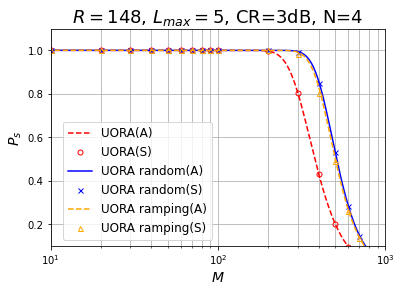

In [128]:
# print(ps_list[4])
# general
plt.semilogx(m_list, ps_list[4], linestyle = '--', color='red', label='UORA(A)')
plt.semilogx(m_list_simu, ps_list_simu_148, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

# random
plt.semilogx(m_list, ps_list_random[4], color='blue', label='UORA random(A)')
plt.semilogx(m_list_simu, ps_list_simu_148_random, label='UORA random(S)', linestyle='None', marker='x', markerfacecolor='None', markeredgecolor='blue', markersize=5)
# ramping
plt.semilogx(m_list, ps_list_ramp[4], linestyle = '--', color='orange', label='UORA ramping(A)')
plt.semilogx(m_list_simu, ps_list_simu_148_ramp, label='UORA ramping(S)', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R=148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$P_s$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.5, 0.3), fontsize = 12)
plt.axis([10,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

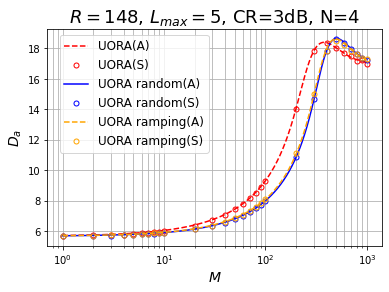

In [129]:
# general
plt.semilogx(m_list, da_list[4], linestyle = '--', color='red', label='UORA(A)')
plt.semilogx(m_list_simu, da_list_simu_148, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

# random
plt.semilogx(m_list, da_list_random[4], color='blue', label='UORA random(A)')
plt.semilogx(m_list_simu, da_list_simu_148_random, label='UORA random(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
# ramping
plt.semilogx(m_list, da_list_ramp[4], linestyle = '--', color='orange', label='UORA ramping(A)')
plt.semilogx(m_list_simu, da_list_simu_148_ramp, label='UORA ramping(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$D_a$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.5, 0.7), fontsize = 12)
# plt.axis([10,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

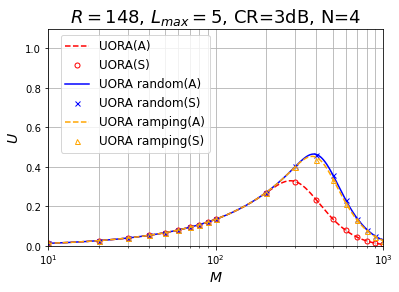

In [130]:
# print(ps_list[4])
# general
plt.semilogx(m_list, u_list[4], linestyle = '--', color='red', label='UORA(A)')
plt.semilogx(m_list_simu, u_list_simu_148, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

# random
plt.semilogx(m_list, u_list_random[4], color='blue', label='UORA random(A)')
plt.semilogx(m_list_simu, u_list_simu_148_random, label='UORA random(S)', linestyle='None', marker='x', markerfacecolor='None', markeredgecolor='blue', markersize=5)
# ramping
plt.semilogx(m_list, u_list_ramp[4], linestyle = '--', color='orange', label='UORA ramping(A)')
plt.semilogx(m_list_simu, u_list_simu_148_ramp, label='UORA ramping(S)', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$U$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.5, 0.7), fontsize = 12)
plt.axis([10,sta_max,0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

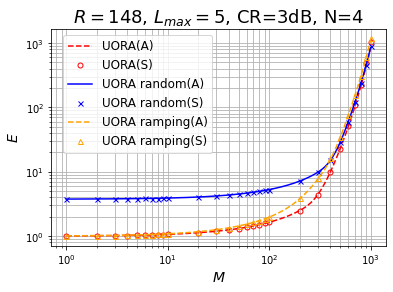

In [131]:
# print(ps_list[4])
# general
plt.plot(m_list, power_list[4], linestyle = '--', color='red', label='UORA(A)')
plt.plot(m_list_simu, power_list_simu_148, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

# random
plt.plot(m_list, power_list_random[4], color='blue', label='UORA random(A)')
plt.plot(m_list_simu, power_list_simu_148_random, label='UORA random(S)', linestyle='None', marker='x', markerfacecolor='None', markeredgecolor='blue', markersize=5)
# ramping
plt.plot(m_list, power_list_ramp[4], linestyle = '--', color='orange', label='UORA ramping(A)')
plt.plot(m_list_simu, power_list_simu_148_ramp, label='UORA ramping(S)', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.yscale('log')
plt.xscale('log')
plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$E$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.5, 0.7), fontsize = 12)
# plt.axis([10,sta_max,0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

# Scenario II ($R$ ---> $E$)
Scenario II was designed to investigate the impact of different numbers of RA-RU on power efficiency.

- Figure: $E$ for [$R=9$, $R=18$, $R=37$, $R=74$]
- Parameters: $C=3dB, L_{max}=5, OCW_{min}=7, OCW_{max}=31$, $N=4$
- x-axis: M STAs (10-200)

In [15]:
R = [9,18,37,74,148]
Lmax = 5
sta_max = 200
# sta_max = 500
m_list = [i for i in range(1, sta_max+1)]

ps_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_ramp  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

power_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
power_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]


# Random
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_random(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=6, step=4)
        ps_list_random[idx][sta-1] = Ps
        da_list_random[idx][sta-1] = Da
        u_list_random[idx][sta-1] = U
        power_list_random[idx][sta-1] = power

# RampUp
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_rampup(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=6, step=4)
        ps_list_ramp[idx][sta-1] = Ps
        da_list_ramp[idx][sta-1] = Da
        u_list_ramp[idx][sta-1] = U
        power_list_ramp[idx][sta-1] = power

### random simu result

In [16]:
# Simulation r

# m_list_simu = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
m_list_simu = [(i+1)*10 for i in range(20)]

ps_list_simu_9_random = [1.0, 0.9985000000000003, 0.9739333333333318, 0.8806500000000003, 0.7229999999999995, 0.562016666666667, 0.4301142857142842, 0.3334250000000003, 0.2633222222222221, 0.2148799999999997, 0.17747272727272725, 0.1494916666666668, 0.12896923076923086, 0.113935714285714, 0.09974666666666697, 0.0906249999999999, 0.08232941176470639, 0.07522777777777803, 0.06844736842105258, 0.06428999999999993]
da_list_simu_9_random = [11.43846990000004, 19.03200765175449, 27.427261524746914, 33.97115455373337, 39.092721365786936, 43.1386767442284, 46.45350815197853, 49.554631922306136, 52.407585956812945, 55.010370836070315, 57.080090187862275, 59.14068401166659, 60.96969336262054, 62.48298344481745, 63.764705639671, 64.93030988090963, 65.83113380524621, 66.5885271353087, 67.32920861071733, 67.87887634396074]
t_list_simu_9_random = [0.6666666666666636, 1.331333333333327, 1.9478666666666635, 2.3484000000000065, 2.410000000000002, 2.248066666666668, 2.0071999999999997, 1.7782666666666636, 1.579933333333333, 1.4325333333333339, 1.30146666666667, 1.1959333333333344, 1.1177333333333355, 1.0634000000000026, 0.9974666666666686, 0.9666666666666652, 0.9330666666666663, 0.9027333333333322, 0.8669999999999982, 0.8571999999999991]
u_list_simu_9_random = [0.074074074074075, 0.1479259259259277, 0.2164296296296315, 0.26093333333333385, 0.26777777777777784, 0.24978518518518567, 0.22302222222222212, 0.19758518518518497, 0.17554814814814793, 0.15917037037037024, 0.14460740740740746, 0.13288148148148143, 0.12419259259259274, 0.11815555555555553, 0.11082962962962992, 0.10740740740740738, 0.1036740740740741, 0.10030370370370371, 0.09633333333333324, 0.09524444444444445]
power_list_simu_9_random = [6.2559, 8.898803801169606, 11.485973614584648, 13.378917089045272, 14.67495424044071, 15.589921175327278, 16.249958261560362, 16.827348856532097, 17.156776312447473, 17.54866889003913, 17.89639867242932, 18.053956149132706, 18.217321820445573, 18.34502313221677, 18.548729195003894, 18.61959014744697, 18.747145054925614, 18.83517425652807, 18.828428032927693, 18.755919092208092]


ps_list_simu_18_random = [1.0, 1.0, 0.9986666666666666, 0.9855500000000047, 0.927380000000004, 0.8050333333333336, 0.6566857142857149, 0.5067749999999998, 0.39669999999999933, 0.3091499999999998, 0.24810909090909133, 0.19992500000000024, 0.16466153846153916, 0.13912857142857132, 0.12039333333333378, 0.10278125000000003, 0.09153529411764745, 0.08137222222222242, 0.07293684210526316, 0.06641500000000002]
da_list_simu_18_random = [7.686915000000027, 10.661552550000053, 14.131265440585658, 18.007146615687272, 21.75297157224233, 24.605449264135988, 26.733319319186798, 28.5468898814643, 30.11944969111567, 31.649800749145513, 33.12913044772878, 34.52372729874843, 35.70015711464792, 36.950485215192934, 37.987011745335224, 39.04386941657963, 39.76482418569136, 40.63019731870784, 41.150810942915804, 41.8253222876963]
t_list_simu_18_random = [1.25, 2.5, 3.745, 4.92775, 5.796125, 6.03775, 5.746, 5.06775, 4.462875, 3.864375, 3.4115, 2.998875, 2.67575, 2.43475, 2.257375, 2.055625, 1.945125, 1.830875, 1.73225, 1.660375]
u_list_simu_18_random = [0.06944444444444328, 0.13888888888888656, 0.20805555555555794, 0.2737638888888866, 0.32200694444444494, 0.335430555555556, 0.31922222222222285, 0.2815416666666671, 0.2479375000000003, 0.21468750000000023, 0.18952777777777796, 0.166604166666667, 0.1486527777777775, 0.13526388888888874, 0.12540972222222227, 0.11420138888888902, 0.10806250000000003, 0.10171527777777796, 0.09623611111111108, 0.09224305555555558]
power_list_simu_18_random = [4.988899999999996, 6.679949999999997, 8.540369886881956, 10.398090459212824, 12.208950257846062, 13.495141418847314, 14.404137237417645, 15.209988041908057, 15.698237642621997, 16.15278195778164, 16.68094663145668, 16.97367029851573, 17.35716833008201, 17.686648692950104, 17.97046700835478, 18.195418336847258, 18.325839009547614, 18.35830632878042, 18.577380299888304, 18.615536050392368]


ps_list_simu_37_random = [1.0, 1.0, 1.0, 1.0, 0.99978, 0.9981500000000006, 0.9869142857142832, 0.9495249999999997, 0.8693555555555568, 0.7507900000000004, 0.6165727272727264, 0.4880666666666665, 0.37839230769230675, 0.2889857142857146, 0.22704666666666654, 0.17313749999999997, 0.13443529411764735, 0.10076666666666659, 0.0780263157894736, 0.06056000000000006]
da_list_simu_37_random = [6.637410000000002, 7.714996350000041, 8.838912199999987, 10.07141872500008, 11.54978371147959, 13.06431356623755, 14.809213382614535, 16.329342124953662, 17.44977415030581, 18.08039988773492, 18.404231447411927, 18.498859368491132, 18.41683528576877, 18.305456952550493, 18.151248994175695, 17.95574163396167, 17.935995584667204, 17.670992443051908, 17.594821148125735, 17.490048758649138]
t_list_simu_37_random = [2.0, 4.0, 6.0, 8.0, 9.997800000000002, 11.97780000000001, 13.816800000000006, 15.192399999999996, 15.648399999999995, 15.015800000000004, 13.564599999999986, 11.713600000000014, 9.8382, 8.0916, 6.8114000000000114, 5.540399999999999, 4.5708, 3.6275999999999993, 2.9650000000000007, 2.422399999999998]
u_list_simu_37_random = [0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21621621621621823, 0.2702108108108064, 0.3237243243243232, 0.3734270270270278, 0.41060540540540624, 0.42292972972972914, 0.4058324324324312, 0.36661081081081043, 0.3165837837837833, 0.26589729729729755, 0.21869189189189162, 0.18409189189189185, 0.14974054054054053, 0.12353513513513502, 0.09804324324324318, 0.08013513513513504, 0.06547027027027057]
power_list_simu_37_random = [4.405600000000003, 5.051950000000002, 5.8604, 6.674699999999998, 7.6518566156462535, 8.653015782522573, 9.783085142504792, 10.84821971074289, 11.640609731909436, 12.142145321158758, 12.453929288694876, 12.547920930174609, 12.565637220692524, 12.524514808391082, 12.500249978151476, 12.390060183204632, 12.370066021550635, 12.261020918054871, 12.207711453395177, 12.120135774078644]


ps_list_simu_74_random = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999750000000001, 0.9999555555555555, 0.9999, 0.9993636363636367, 0.9979583333333345, 0.9948692307692296, 0.9892857142857093, 0.9735600000000095, 0.9496312499999985, 0.9124764705882322, 0.8698611111111112, 0.8137473684210501, 0.7494550000000002]
da_list_simu_74_random = [6.168820199999948, 6.700096650000014, 7.170861099999994, 7.727193300000044, 8.25580344, 8.887227250000016, 9.517186885714287, 10.124884931730849, 10.833177990909093, 11.539101973469402, 12.359712371842699, 13.147396545273644, 13.976635270899902, 14.792900611103283, 15.644928675109885, 16.35365417989693, 16.94455788747141, 17.425162621150413, 17.81956256373536, 18.115619671852844]
t_list_simu_74_random = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 15.999600000000001, 17.9992, 19.998, 21.98599999999999, 23.950999999999972, 25.866599999999917, 27.699999999999957, 29.206799999999955, 30.38819999999995, 31.02419999999997, 31.314999999999976, 30.922400000000003, 29.97820000000003]
u_list_simu_74_random = [0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891891891891912, 0.21621081081081284, 0.24323243243243808, 0.2702432432432388, 0.29710810810810356, 0.323662162162161, 0.34954864864865137, 0.3743243243243247, 0.39468648648648663, 0.4106513513513517, 0.41924594594594516, 0.4231756756756758, 0.4178702702702697, 0.4051108108108103]
power_list_simu_74_random = [4.067499999999999, 4.453699999999998, 4.7212333333333305, 5.094874999999999, 5.430159999999998, 5.8655500000000025, 6.272542857142855, 6.68540320512821, 7.145338131313135, 7.630599999999998, 8.193777488841913, 8.689034297712668, 9.227885737914248, 9.794447680474418, 10.336694123289254, 10.85651843497912, 11.276942820281906, 11.631061127700093, 11.916939246962507, 12.174554343319892]


ps_list_simu_148_random = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999777777777777, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999882352941176, 0.9999722222222222, 0.999936842105263, 0.9999250000000001]
da_list_simu_148_random = [5.900487299999912, 6.174209549999991, 6.480078799999998, 6.699103875000028, 6.942050100000006, 7.214637750000001, 7.470125357142863, 7.731731700000039, 8.030642929545472, 8.327623620000006, 8.574172200000001, 8.882310650000012, 9.17223731538462, 9.511189714285717, 9.801544659999983, 10.157861062500059, 10.476158671638633, 10.843429915600609, 11.195024071429177, 11.569368038551842]
t_list_simu_148_random = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 17.999599999999997, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 33.9996, 35.999, 37.9976, 39.99699999999999]
u_list_simu_148_random = [0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12161891891892176, 0.13513513513513292, 0.14864864864864633, 0.16216216216216145, 0.17567567567567705, 0.1891891891891912, 0.2027027027027067, 0.21621621621621823, 0.22972702702703035, 0.24323648648649215, 0.2567405405405346, 0.2702499999999956]
power_list_simu_148_random = [3.8600000000000008, 4.076899999999998, 4.301533333333325, 4.427450000000005, 4.595559999999995, 4.762250000000007, 4.952671428571423, 5.088312500000002, 5.301215656565658, 5.507170000000009, 5.669618181818182, 5.87155833333334, 6.053884615384611, 6.2956357142857104, 6.48323333333333, 6.720875000000002, 6.929920728291321, 7.172076501091512, 7.392801388917793, 7.658367369169075]

### Ramp up simu result (CR=6)

In [17]:
# Simulation r

# m_list_simu = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
m_list_simu = [(i+1)*10 for i in range(20)]

ps_list_simu_9_ramp = [1.0, 0.9976500000000006, 0.966299999999998, 0.8606749999999999, 0.6946800000000013, 0.5363500000000007, 0.4110285714285698, 0.3178250000000001, 0.2497555555555554, 0.20514999999999925, 0.16869090909090922, 0.1441000000000003, 0.12326153846153877, 0.10923571428571409, 0.09600666666666705, 0.08781875000000004, 0.07886470588235353, 0.07216666666666699, 0.06580000000000001, 0.061774999999999934]
da_list_simu_9_ramp = [11.494065300000019, 19.72986627280712, 28.032921313626336, 34.72442163208014, 39.51442405158269, 43.43810233900669, 46.70856281005599, 49.76069908580669, 52.72146119808534, 55.48506835127859, 57.52140839167424, 59.49210816978654, 61.23327015379131, 62.72248794202405, 64.16555975082467, 65.03365821637887, 66.17318737463921, 66.82759445958114, 67.43494452097359, 68.13862499002502]
t_list_simu_9_ramp = [0.6666666666666636, 1.3301999999999943, 1.932599999999996, 2.2951333333333395, 2.315600000000004, 2.1454000000000026, 1.9181333333333344, 1.695066666666664, 1.4985333333333342, 1.3676666666666704, 1.2370666666666703, 1.1528000000000025, 1.0682666666666674, 1.0195333333333336, 0.9600666666666658, 0.9367333333333318, 0.8937999999999977, 0.8659999999999982, 0.833466666666665, 0.823666666666665]
u_list_simu_9_ramp = [0.074074074074075, 0.1478000000000017, 0.21473333333333458, 0.255014814814815, 0.2572888888888894, 0.23837777777777777, 0.21312592592592552, 0.18834074074074061, 0.16650370370370354, 0.15196296296296277, 0.13745185185185196, 0.12808888888888914, 0.1186962962962965, 0.11328148148148157, 0.10667407407407421, 0.10408148148148152, 0.0993111111111112, 0.09622222222222222, 0.09260740740740753, 0.0915185185185186]
power_list_simu_9_ramp = [2.6219999999999994, 5.6192935672514635, 9.403043729564347, 12.577969598187206, 14.679109003100573, 16.21741267691252, 17.344452989677098, 18.29302120793716, 19.218544457211387, 20.0033117472963, 20.4961248749174, 21.017323006959323, 21.41449169305624, 21.718531960552763, 22.007112199453093, 22.177567352006125, 22.39358101874197, 22.470154974105654, 22.57564468431469, 22.670034733309393]


ps_list_simu_18_ramp = [1.0, 1.0, 0.9983333333333335, 0.9788750000000048, 0.9041400000000014, 0.7682666666666673, 0.6137142857142871, 0.4788749999999996, 0.3750222222222217, 0.2924399999999997, 0.23224545454545462, 0.19205833333333325, 0.15574615384615473, 0.1329714285714286, 0.11336666666666703, 0.09800624999999985, 0.08704117647058862, 0.07665000000000025, 0.06972105263157893, 0.06387999999999992]
da_list_simu_18_ramp = [7.879229700000037, 10.81046880000005, 14.71550324247401, 18.592715257621812, 22.194837715246507, 24.879977594841673, 26.988203156523003, 28.80864419400601, 30.372984123395312, 31.858532962389322, 33.38292227180211, 34.58116031461436, 36.016628388162765, 37.131267760220815, 38.22647069415085, 39.20671622285835, 40.02796131532215, 40.73104401453562, 41.30351582307359, 41.87141412426408]
t_list_simu_18_ramp = [1.25, 2.5, 3.74375, 4.894375, 5.650875, 5.762, 5.37, 4.78875, 4.219, 3.6555, 3.193375, 2.880875, 2.530875, 2.327, 2.125625, 1.960125, 1.849625, 1.724625, 1.655875, 1.597]
u_list_simu_18_ramp = [0.06944444444444328, 0.13888888888888656, 0.2079861111111134, 0.2719097222222203, 0.3139375000000006, 0.3201111111111107, 0.29833333333333373, 0.26604166666666673, 0.23438888888888915, 0.20308333333333342, 0.17740972222222212, 0.16004861111111113, 0.1406041666666665, 0.12927777777777794, 0.11809027777777807, 0.10889583333333346, 0.10275694444444448, 0.0958125, 0.09199305555555551, 0.08872222222222195]
power_list_simu_18_ramp = [1.8363999999999983, 3.2153, 5.512121145776316, 8.280582653310208, 10.995197951445391, 12.96839780337792, 14.456801461712484, 15.614057089171364, 16.571020311672406, 17.427184686325422, 18.227078306135592, 18.86833654723926, 19.644028359446157, 20.1884467244409, 20.694650402581164, 21.17209134909541, 21.49152470002253, 21.806763255433356, 22.02682274996918, 22.24498245304636]


ps_list_simu_37_ramp = [1.0, 1.0, 1.0, 0.9997999999999999, 0.9993200000000002, 0.9949166666666674, 0.9742428571428561, 0.9182125000000013, 0.8232888888888895, 0.6966000000000007, 0.5620909090909092, 0.44609166666666633, 0.3443461538461553, 0.2674, 0.2057666666666667, 0.15691875000000005, 0.12032352941176512, 0.09298888888888894, 0.0709631578947368, 0.05550499999999991]
da_list_simu_37_ramp = [6.640813800000002, 7.819379550000042, 9.027634000000011, 10.323471607894799, 11.773824567500002, 13.578760944756878, 15.203911124880355, 16.60235714267966, 17.5531105538535, 18.04724387535872, 18.262307990235016, 18.31965399607261, 18.270890708531468, 18.154188476910797, 18.012622014174802, 17.87963661868377, 17.800331533320968, 17.688059818177795, 17.526244819915647, 17.464145569500737]
t_list_simu_37_ramp = [2.0, 4.0, 6.0, 7.998399999999999, 9.993200000000005, 11.93900000000002, 13.639400000000025, 14.691400000000021, 14.819200000000002, 13.932000000000006, 12.365999999999984, 10.7062, 8.95299999999999, 7.487199999999996, 6.173000000000003, 5.021400000000002, 4.090999999999998, 3.3476000000000012, 2.6965999999999957, 2.2202000000000015]
u_list_simu_37_ramp = [0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21617297297297497, 0.27008648648648215, 0.3226756756756747, 0.36863243243243266, 0.3970648648648646, 0.40051891891891844, 0.3765405405405398, 0.33421621621621606, 0.28935675675675665, 0.24197297297297285, 0.20235675675675663, 0.16683783783783795, 0.1357135135135136, 0.11056756756756739, 0.09047567567567548, 0.07288108108108117, 0.06000540540540577]
power_list_simu_37_ramp = [1.356200000000006, 1.8598000000000012, 2.4942666666666673, 3.3265973684210572, 4.446063333333337, 6.090020774454277, 7.725692951717012, 9.192862468641017, 10.238313128889917, 10.788133002080269, 11.027263129361263, 11.10580642922579, 11.067899439651159, 10.944667359629744, 10.808308282130305, 10.669011119475236, 10.56632426576491, 10.470103450387835, 10.31500708615371, 10.258795685460044]


ps_list_simu_74_ramp = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999714285714285, 0.9999750000000001, 0.9999333333333332, 0.9996200000000003, 0.9984454545454555, 0.9958083333333354, 0.9884769230769208, 0.975464285714283, 0.95345333333334, 0.9212687500000005, 0.8752411764705857, 0.8248666666666686, 0.7597894736842096, 0.694410000000001]
da_list_simu_74_ramp = [6.16882019999995, 6.687048750000013, 7.300772799999991, 7.839235050000047, 8.429851079999999, 9.024513850000014, 9.671523472689065, 10.4030492134616, 11.081973422727275, 11.900776025114416, 12.723834987206216, 13.578892547098512, 14.437286724698247, 15.267573914976344, 16.010850628427832, 16.60227393488331, 17.11166203752559, 17.5197082614724, 17.860282004640418, 18.03993998990313]
t_list_simu_74_ramp = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 13.999600000000001, 15.999600000000001, 17.998800000000003, 19.9924, 21.965799999999987, 23.899399999999968, 25.70039999999993, 27.312999999999953, 28.603599999999947, 29.480600000000017, 29.75819999999999, 29.695199999999996, 28.872000000000007, 27.77639999999999]
u_list_simu_74_ramp = [0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891837837837858, 0.2162108108108128, 0.2432270270270327, 0.27016756756756327, 0.29683513513513055, 0.32296486486486414, 0.34730270270270475, 0.36909459459459326, 0.38653513513513466, 0.3983864864864858, 0.40213783783783735, 0.40128648648648624, 0.39016216216216143, 0.3753567567567565]
power_list_simu_74_ramp = [1.177000000000003, 1.3742000000000005, 1.6205999999999994, 1.8617500000000005, 2.1586399999999992, 2.4828333333333314, 2.878711764705883, 3.3740794871794897, 3.88538333333333, 4.554224741290456, 5.274683882389382, 6.0840280236561295, 6.935158449047179, 7.780062263606611, 8.560646726999336, 9.192281265955184, 9.756800186491487, 10.195402835545513, 10.5751333881423, 10.776706765351415]


ps_list_simu_148_ramp = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999866666666667, 0.999975, 0.9999941176470588, 0.9999333333333336, 0.9998684210526317, 0.9996550000000002]
da_list_simu_148_ramp = [5.903891099999907, 6.216189749999987, 6.475540399999992, 6.755975700000016, 7.0101261000000115, 7.276095249999991, 7.561703785714301, 7.840511475000039, 8.149642700000022, 8.426901119999993, 8.73064385454546, 9.051980625000006, 9.365773892307697, 9.70646247857142, 10.02576615189189, 10.410339632990535, 10.742960889836398, 11.112170413483131, 11.52030142515507, 11.90915163062815]
t_list_simu_148_ramp = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 29.999599999999997, 31.9992, 33.9998, 35.9976, 37.99499999999998, 39.986199999999975]
u_list_simu_148_ramp = [0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.14864864864864633, 0.16216216216216145, 0.17567567567567705, 0.1891891891891912, 0.202700000000004, 0.2162108108108128, 0.2297283783783817, 0.24322702702703264, 0.25672297297296703, 0.2701770270270227]
power_list_simu_148_ramp = [1.0822000000000012, 1.1931000000000032, 1.29053333333334, 1.3960500000000011, 1.5008400000000022, 1.610533333333334, 1.7339999999999995, 1.861349999999998, 2.0135777777777784, 2.1526799999999997, 2.317963636363639, 2.501250000000004, 2.684630769230769, 2.8993714285714307, 3.1117803603603567, 3.3788088607594995, 3.612220048729549, 3.9011431960049925, 4.227942258662746, 4.559207986904223]

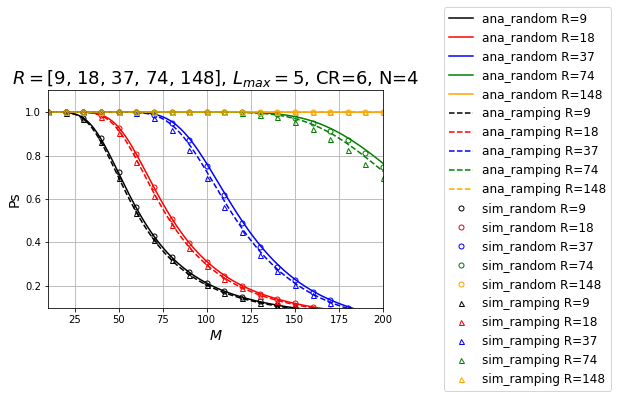

In [18]:
plt.plot(m_list, ps_list_random[0], color='black', label='ana_random R=9')
plt.plot(m_list, ps_list_random[1], color='red', label='ana_random R=18')
plt.plot(m_list, ps_list_random[2], color='blue', label='ana_random R=37')
plt.plot(m_list, ps_list_random[3], color='green', label='ana_random R=74')
plt.plot(m_list, ps_list_random[4], color='orange', label='ana_random R=148')

plt.plot(m_list, ps_list_ramp[0], linestyle = '--', color='black', label='ana_ramping R=9')
plt.plot(m_list, ps_list_ramp[1], linestyle = '--', color='red', label='ana_ramping R=18')
plt.plot(m_list, ps_list_ramp[2], linestyle = '--', color='blue', label='ana_ramping R=37')
plt.plot(m_list, ps_list_ramp[3], linestyle = '--', color='green', label='ana_ramping R=74')
plt.plot(m_list, ps_list_ramp[4], linestyle = '--', color='orange', label='ana_ramping R=148')

plt.plot(m_list_simu, ps_list_simu_9_random, label='sim_random R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, ps_list_simu_18_random, label='sim_random R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, ps_list_simu_37_random, label='sim_random R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, ps_list_simu_74_random, label='sim_random R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, ps_list_simu_148_random, label='sim_random R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.plot(m_list_simu, ps_list_simu_9_ramp, label='sim_ramping R=9', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, ps_list_simu_18_ramp, label='sim_ramping R=18', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, ps_list_simu_37_ramp, label='sim_ramping R=37', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, ps_list_simu_74_ramp, label='sim_ramping R=74', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, ps_list_simu_148_ramp, label='sim_ramping R=148', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(R) +', $L_{max}=$' + str(Lmax) + ', CR=6, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Ps", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
plt.axis([10,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

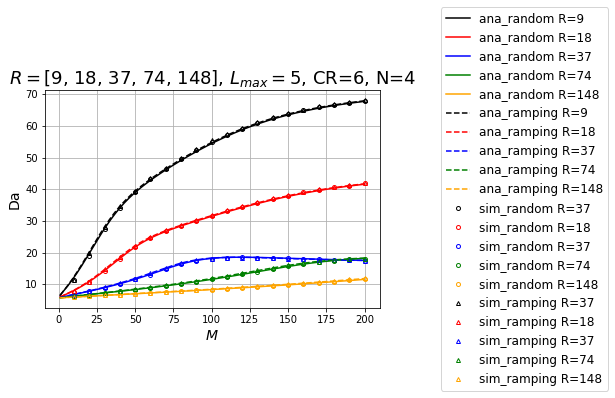

In [19]:
plt.plot(m_list, da_list_random[0], color='black', label='ana_random R=9')
plt.plot(m_list, da_list_random[1], color='red', label='ana_random R=18')
plt.plot(m_list, da_list_random[2], color='blue', label='ana_random R=37')
plt.plot(m_list, da_list_random[3], color='green', label='ana_random R=74')
plt.plot(m_list, da_list_random[4], color='orange', label='ana_random R=148')

plt.plot(m_list, da_list_ramp[0], linestyle = '--', color='black', label='ana_ramping R=9')
plt.plot(m_list, da_list_ramp[1], linestyle = '--', color='red', label='ana_ramping R=18')
plt.plot(m_list, da_list_ramp[2], linestyle = '--', color='blue', label='ana_ramping R=37')
plt.plot(m_list, da_list_ramp[3], linestyle = '--', color='green', label='ana_ramping R=74')
plt.plot(m_list, da_list_ramp[4], linestyle = '--', color='orange', label='ana_ramping R=148')

plt.plot(m_list_simu, da_list_simu_9_random, label='sim_random R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=4)
plt.plot(m_list_simu, da_list_simu_18_random, label='sim_random R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=4)
plt.plot(m_list_simu, da_list_simu_37_random, label='sim_random R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=4)
plt.plot(m_list_simu, da_list_simu_74_random, label='sim_random R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=4)
plt.plot(m_list_simu, da_list_simu_148_random, label='sim_random R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=4)

plt.plot(m_list_simu, da_list_simu_9_ramp, label='sim_ramping R=37', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='black', markersize=4)
plt.plot(m_list_simu, da_list_simu_18_ramp, label='sim_ramping R=18', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='red', markersize=4)
plt.plot(m_list_simu, da_list_simu_37_ramp, label='sim_ramping R=37', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='blue', markersize=4)
plt.plot(m_list_simu, da_list_simu_74_ramp, label='sim_ramping R=74', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='green', markersize=4)
plt.plot(m_list_simu, da_list_simu_148_ramp, label='sim_ramping R=148', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=4)


plt.title('$R = $' + str(R) +', $L_{max}=$' + str(Lmax) + ', CR=6, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Da", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,60]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

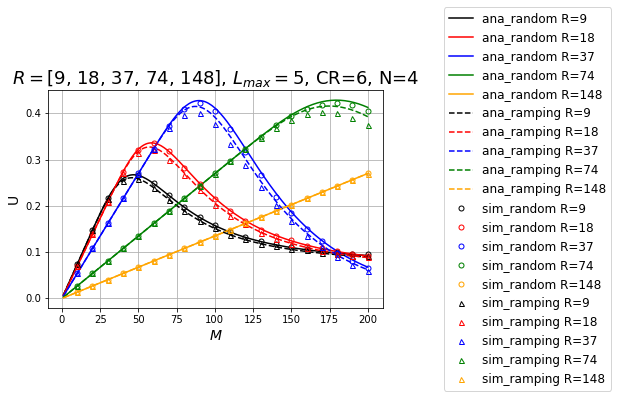

In [20]:
plt.plot(m_list, u_list_random[0], color='black', label='ana_random R=9')
plt.plot(m_list, u_list_random[1], color='red', label='ana_random R=18')
plt.plot(m_list, u_list_random[2], color='blue', label='ana_random R=37')
plt.plot(m_list, u_list_random[3], color='green', label='ana_random R=74')
plt.plot(m_list, u_list_random[4], color='orange', label='ana_random R=148')

plt.plot(m_list, u_list_ramp[0], linestyle = '--', color='black', label='ana_ramping R=9')
plt.plot(m_list, u_list_ramp[1], linestyle = '--', color='red', label='ana_ramping R=18')
plt.plot(m_list, u_list_ramp[2], linestyle = '--', color='blue', label='ana_ramping R=37')
plt.plot(m_list, u_list_ramp[3], linestyle = '--', color='green', label='ana_ramping R=74')
plt.plot(m_list, u_list_ramp[4], linestyle = '--', color='orange', label='ana_ramping R=148')

plt.plot(m_list_simu, u_list_simu_9_random, label='sim_random R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, u_list_simu_18_random, label='sim_random R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, u_list_simu_37_random, label='sim_random R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, u_list_simu_74_random, label='sim_random R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, u_list_simu_148_random, label='sim_random R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.plot(m_list_simu, u_list_simu_9_ramp, label='sim_ramping R=9', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, u_list_simu_18_ramp, label='sim_ramping R=18', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, u_list_simu_37_ramp, label='sim_ramping R=37', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, u_list_simu_74_ramp, label='sim_ramping R=74', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, u_list_simu_148_ramp, label='sim_ramping R=148', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max}=$' + str(Lmax) + ', CR=6, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("U", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

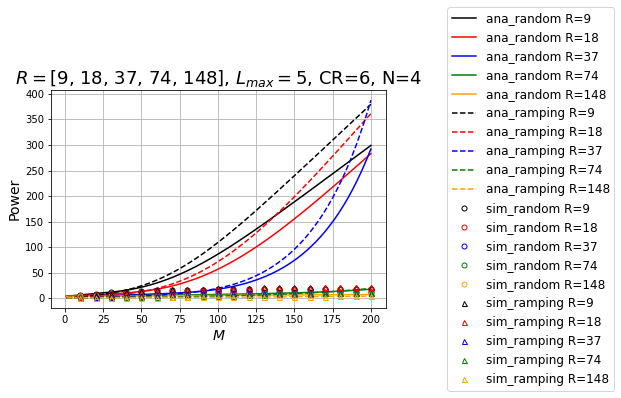

In [21]:
plt.plot(m_list, power_list_random[0], color='black', label='ana_random R=9')
plt.plot(m_list, power_list_random[1], color='red', label='ana_random R=18')
plt.plot(m_list, power_list_random[2], color='blue', label='ana_random R=37')
plt.plot(m_list, power_list_random[3], color='green', label='ana_random R=74')
plt.plot(m_list, power_list_random[4], color='orange', label='ana_random R=148')

plt.plot(m_list, power_list_ramp[0], linestyle = '--', color='black', label='ana_ramping R=9')
plt.plot(m_list, power_list_ramp[1], linestyle = '--', color='red', label='ana_ramping R=18')
plt.plot(m_list, power_list_ramp[2], linestyle = '--', color='blue', label='ana_ramping R=37')
plt.plot(m_list, power_list_ramp[3], linestyle = '--', color='green', label='ana_ramping R=74')
plt.plot(m_list, power_list_ramp[4], linestyle = '--', color='orange', label='ana_ramping R=148')

plt.plot(m_list_simu, power_list_simu_9_random, label='sim_random R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, power_list_simu_18_random, label='sim_random R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, power_list_simu_37_random, label='sim_random R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, power_list_simu_74_random, label='sim_random R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, power_list_simu_148_random, label='sim_random R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.plot(m_list_simu, power_list_simu_9_ramp, label='sim_ramping R=9', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, power_list_simu_18_ramp, label='sim_ramping R=18', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, power_list_simu_37_ramp, label='sim_ramping R=37', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, power_list_simu_74_ramp, label='sim_ramping R=74', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, power_list_simu_148_ramp, label='sim_ramping R=148', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max}=$' + str(Lmax) + ', CR=6, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Power", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

# CR=3

In [22]:
R = [9,18,37,74,148]
Lmax = 5
sta_max = 200
# sta_max = 500
m_list = [i for i in range(1, sta_max+1)]

ps_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_ramp  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

power_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
power_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

# Random
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_random(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=3, step=4)
        ps_list_random[idx][sta-1] = Ps
        da_list_random[idx][sta-1] = Da
        u_list_random[idx][sta-1] = U
        power_list_random[idx][sta-1] = power

# RampUp
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_rampup(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=3, step=4)
        ps_list_ramp[idx][sta-1] = Ps
        da_list_ramp[idx][sta-1] = Da
        u_list_ramp[idx][sta-1] = U
        power_list_ramp[idx][sta-1] = power

### random simu result

In [23]:
# Simulation r

# m_list_simu = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
m_list_simu = [(i+1)*10 for i in range(20)]

ps_list_simu_9_random = [1.0, 0.9992000000000003, 0.9868666666666664, 0.921100000000001, 0.7861599999999983, 0.6252000000000002, 0.48565714285714195, 0.3754499999999999, 0.2992555555555553, 0.24246999999999966, 0.19859090909090923, 0.16803333333333365, 0.143307692307693, 0.1260857142857144, 0.11149333333333382, 0.09946250000000002, 0.09002941176470612, 0.08245555555555562, 0.07583157894736821, 0.07055000000000007]
da_list_simu_9_random = [10.784373000000024, 17.63806529561412, 25.6030912318618, 32.34681481219985, 37.752948992648314, 41.989665250044126, 45.43022469644156, 48.61469746278638, 51.2876643439078, 53.9426705075223, 56.28370345297647, 58.38328997328168, 60.28627475476477, 61.760050202708456, 63.126469180566026, 64.49995273655517, 65.49606442948483, 66.26043895866985, 66.88655889808764, 67.53105687190096]
t_list_simu_9_random = [0.6666666666666636, 1.3322666666666607, 1.973733333333333, 2.4562666666666653, 2.620533333333329, 2.500800000000001, 2.2664000000000026, 2.0023999999999993, 1.7955333333333343, 1.616466666666668, 1.4563333333333355, 1.3442666666666692, 1.2420000000000033, 1.1768000000000012, 1.114933333333334, 1.0609333333333348, 1.0203333333333338, 0.9894666666666654, 0.9605333333333332, 0.9406666666666664]
u_list_simu_9_random = [0.074074074074075, 0.14802962962963145, 0.21930370370370653, 0.27291851851851834, 0.29117037037036997, 0.27786666666666643, 0.2518222222222227, 0.22248888888888899, 0.19950370370370396, 0.17960740740740683, 0.16181481481481477, 0.14936296296296295, 0.1380000000000001, 0.13075555555555574, 0.12388148148148174, 0.11788148148148164, 0.11337037037037055, 0.10994074074074087, 0.10672592592592592, 0.10451851851851868]
power_list_simu_9_random = [6.0235999999999965, 8.404516374268997, 10.973920353528973, 12.95900926860357, 14.327624394363491, 15.387232584903364, 16.026365811696003, 16.6654320508845, 17.00892118872878, 17.493143161568142, 17.727689763432554, 17.99587231647741, 18.269478143932748, 18.430037727432303, 18.472812770798345, 18.585286183015594, 18.763482189465236, 18.73605240736132, 18.91151950919814, 18.925321186692695]


ps_list_simu_18_random = [1.0, 1.0, 0.9995333333333334, 0.9943000000000024, 0.9627200000000073, 0.8684499999999992, 0.7305142857142857, 0.5809125000000007, 0.4525222222222221, 0.35513000000000006, 0.2849181818181817, 0.22958333333333322, 0.18796923076923078, 0.1574357142857139, 0.13554666666666668, 0.11608124999999991, 0.10342352941176516, 0.08973333333333335, 0.08141052631578925, 0.07371499999999993]
da_list_simu_18_random = [7.459995000000027, 9.959518800000048, 13.044685765763516, 16.76713475687369, 20.375270149097997, 23.603873454407527, 26.00610635993148, 27.91958054668412, 29.55356907377077, 31.195143353814814, 32.63750416982867, 33.96107131348016, 35.3860307287702, 36.45319012926977, 37.48104797647525, 38.63566398950692, 39.4560518456507, 40.24292611684574, 40.854261144575766, 41.45166720061202]
t_list_simu_18_random = [1.25, 2.5, 3.74825, 4.9715, 6.017, 6.513375, 6.392, 5.809125, 5.090875, 4.439125, 3.917625, 3.44375, 3.0545, 2.755125, 2.5415, 2.321625, 2.19775, 2.019, 1.9335, 1.842875]
u_list_simu_18_random = [0.06944444444444328, 0.13888888888888656, 0.20823611111111356, 0.27619444444444075, 0.33427777777777795, 0.36185416666666614, 0.35511111111111116, 0.3227291666666663, 0.28282638888888867, 0.24661805555555563, 0.21764583333333343, 0.1913194444444445, 0.16969444444444443, 0.15306250000000013, 0.14119444444444426, 0.12897916666666653, 0.12209722222222233, 0.11216666666666686, 0.10741666666666672, 0.10238194444444464]
power_list_simu_18_random = [4.919800000000001, 6.310800000000004, 7.979037110016413, 9.822122841928103, 11.577760699699372, 13.112454091582439, 14.146840847019668, 14.954787487237901, 15.519840093574947, 16.09853396223049, 16.533515484612458, 16.943849154261144, 17.369089558801104, 17.66224572784426, 17.8067727368299, 18.078355984583247, 18.262850888212437, 18.48408491195904, 18.45147792214715, 18.7277315150222]


ps_list_simu_37_random = [1.0, 1.0, 1.0, 1.0, 0.9999600000000001, 0.9993500000000003, 0.9964857142857126, 0.9814874999999983, 0.9382333333333326, 0.8472299999999987, 0.728290909090909, 0.5931750000000006, 0.4663384615384586, 0.3637999999999997, 0.27858666666666676, 0.21635000000000015, 0.165158823529412, 0.12532777777777768, 0.09738421052631555, 0.07541000000000006]
da_list_simu_37_random = [6.509200199999997, 7.432764600000034, 8.435372800000017, 9.576024000000066, 10.826642638775514, 12.188808393598118, 13.798060361879907, 15.407489027932671, 16.823302816077753, 17.831549184870312, 18.357311325119895, 18.625362298830133, 18.636296636827222, 18.5490982305578, 18.405913167165327, 18.239836000502642, 17.980296946245343, 17.852278429010333, 17.808686150732328, 17.606757400754805]
t_list_simu_37_random = [2.0, 4.0, 6.0, 8.0, 9.999600000000001, 11.9922, 13.9508, 15.703799999999973, 16.888199999999998, 16.944599999999987, 16.022400000000022, 14.236200000000007, 12.124799999999995, 10.186399999999995, 8.357599999999996, 6.923200000000005, 5.615399999999989, 4.511799999999995, 3.7005999999999997, 3.0163999999999973]
u_list_simu_37_random = [0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21621621621621823, 0.270259459459455, 0.32411351351351214, 0.3770486486486511, 0.4244270270270284, 0.4564378378378369, 0.45796216216216196, 0.4330378378378372, 0.3847621621621616, 0.32769729729729735, 0.2753081081081083, 0.2258810810810807, 0.1871135135135136, 0.15176756756756773, 0.12194054054054063, 0.10001621621621598, 0.08152432432432422]
power_list_simu_37_random = [4.333600000000003, 4.923749999999997, 5.5754666666666655, 6.324625000000006, 7.154436326530605, 8.05647571712075, 9.159895108928643, 10.21524656023526, 11.216962424844485, 11.934768657330268, 12.387799645374361, 12.626924506466233, 12.662419054065163, 12.664229587725918, 12.631914629438583, 12.55231105419205, 12.374178484938556, 12.338845428883918, 12.329741724866215, 12.162090917827975]


ps_list_simu_74_random = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99999, 0.9998545454545456, 0.9997333333333336, 0.9988692307692305, 0.9969571428571399, 0.9922533333333384, 0.9816937499999988, 0.96485294117648, 0.9374499999999988, 0.8968842105263182, 0.8499050000000028]
da_list_simu_74_random = [6.085994399999954, 6.536714250000021, 7.008613299999989, 7.4504927250000375, 7.967501579999989, 8.479622200000012, 9.014883257142852, 9.569854612500084, 10.190031699999997, 10.843490817272729, 11.48693908432601, 12.288188029717976, 13.020994956087803, 13.821204473351413, 14.639558804522826, 15.442101371037607, 16.19312200375222, 16.816726737065864, 17.368300043571292, 17.829880049044572]
t_list_simu_74_random = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 19.9998, 21.996799999999997, 23.993599999999986, 25.97059999999997, 27.914799999999914, 29.767599999999884, 31.414199999999962, 32.805, 33.74819999999997, 34.081600000000016, 33.99620000000002]
u_list_simu_74_random = [0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891891891891912, 0.21621621621621823, 0.24324324324324892, 0.2702675675675631, 0.29725405405404937, 0.32423783783783655, 0.35095405405405666, 0.37722702702702854, 0.40226486486486757, 0.42451621621621705, 0.4433108108108104, 0.4560567567567566, 0.46056216216216195, 0.4594081081081085]
power_list_simu_74_random = [4.008900000000004, 4.334049999999997, 4.637899999999992, 4.91615, 5.275399999999996, 5.607883333333334, 5.97915714285713, 6.332924999999991, 6.745633333333331, 7.185263333333325, 7.578045067324191, 8.11031249109813, 8.6139711836581, 9.129424590631665, 9.686795496269559, 10.228551650540915, 10.743763963957079, 11.174746436014726, 11.596519838035231, 11.932338512198832]


ps_list_simu_148_random = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999882352941176, 1.0, 0.9999789473684211, 0.999985]
da_list_simu_148_random = [5.885170199999907, 6.13364759999999, 6.31669639999999, 6.572170500000028, 6.794098260000024, 7.032818100000005, 7.278458999999985, 7.499138700000041, 7.747174866666687, 7.994845439999991, 8.248335709090902, 8.518245874999998, 8.759330192307676, 9.06091559999998, 9.302282840000002, 9.62931474375005, 9.9232648340336, 10.241435383333343, 10.555653585386336, 10.851627270226158]
t_list_simu_148_random = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 33.9996, 36.0, 37.999199999999995, 39.999399999999994]
u_list_simu_148_random = [0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.14864864864864633, 0.16216216216216145, 0.17567567567567705, 0.1891891891891912, 0.2027027027027067, 0.21621621621621823, 0.22972702702703035, 0.24324324324324892, 0.25675135135134536, 0.27026621621621183]
power_list_simu_148_random = [3.9142000000000037, 4.0381999999999945, 4.156766666666666, 4.342575, 4.494339999999998, 4.64586666666667, 4.807514285714288, 4.955312500000001, 5.124955555555559, 5.276459999999998, 5.4467363636363615, 5.640133333333331, 5.774769230769226, 5.994714285714291, 6.153873333333339, 6.363699999999997, 6.5560521008403345, 6.7576611111111085, 6.988809854423299, 7.173932883863768]

### Ramp Up simu result

In [24]:
# Rampup

# m_list_simu = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
m_list_simu = [(i+1)*10 for i in range(20)]

ps_list_simu_9_ramp = [1.0, 0.9993500000000003, 0.9839333333333332, 0.9102750000000015, 0.7682200000000007, 0.6078500000000001, 0.46961428571428554, 0.36164999999999997, 0.28467777777777786, 0.2324499999999997, 0.1908818181818184, 0.16269166666666718, 0.13787692307692362, 0.12077142857142847, 0.10812666666666698, 0.09721249999999994, 0.08638235294117688, 0.08090000000000022, 0.07488421052631565, 0.06785500000000008]
da_list_simu_9_ramp = [10.849045200000038, 18.18842094035101, 26.042219966326815, 32.88848261869137, 38.209769012575016, 42.28968054811987, 45.59094121369064, 48.780174473699965, 51.6741287773368, 54.06379354322196, 56.61161527187431, 58.597509869844544, 60.39590147059398, 62.07558254514441, 63.45475456964006, 64.56465090436929, 65.54778908286937, 66.17891025784253, 66.97519408396954, 67.64597856932919]
t_list_simu_9_ramp = [0.6666666666666636, 1.332466666666661, 1.9678666666666664, 2.427400000000005, 2.5607333333333337, 2.4314000000000004, 2.191533333333338, 1.9287999999999994, 1.708066666666667, 1.5496666666666654, 1.3998000000000026, 1.3015333333333374, 1.1949333333333363, 1.1272, 1.0812666666666675, 1.0369333333333348, 0.9789999999999994, 0.9708000000000007, 0.9485333333333338, 0.9047333333333317]
u_list_simu_9_ramp = [0.074074074074075, 0.14805185185185366, 0.2186518518518544, 0.2697111111111111, 0.28452592592592524, 0.2701555555555555, 0.24350370370370403, 0.21431111111111145, 0.18978518518518508, 0.17218518518518505, 0.15553333333333316, 0.14461481481481475, 0.13277037037037048, 0.12524444444444474, 0.12014074074074087, 0.11521481481481503, 0.10877777777777795, 0.10786666666666656, 0.10539259259259254, 0.10052592592592602]
power_list_simu_9_ramp = [2.426199999999997, 4.975796491228061, 8.39842023139834, 11.68847045971796, 14.140563265725834, 15.789688075950513, 16.99115355415785, 18.10035395966342, 18.915671863603343, 19.629142912381393, 20.285710342310857, 20.79165211148157, 21.24198991479423, 21.60103350013041, 21.94694427072996, 22.13169043438645, 22.32148298069473, 22.405601925872155, 22.511731189096302, 22.655686084984872]


ps_list_simu_18_ramp = [1.0, 1.0, 0.9994333333333333, 0.991475000000003, 0.9479200000000059, 0.8430833333333316, 0.7020428571428574, 0.5538625000000004, 0.4307888888888886, 0.3372400000000003, 0.27019090909090904, 0.2179916666666664, 0.18287692307692327, 0.15154285714285687, 0.13003333333333364, 0.11281875000000009, 0.09880000000000033, 0.08727777777777754, 0.07893684210526285, 0.07176500000000002]
da_list_simu_18_ramp = [7.516157700000022, 10.17367455000005, 13.41519228349754, 17.122269618911556, 20.790935664498104, 23.920003660383582, 26.265858353667134, 28.12017444893618, 29.771333464399564, 31.247846646037527, 32.71863997251487, 34.09810873538073, 35.38860282413716, 36.529785820401806, 37.639179218433306, 38.5939146878164, 39.65044624191721, 40.23893897227945, 40.90722730384092, 41.550028114003496]
t_list_simu_18_ramp = [1.25, 2.5, 3.747875, 4.957375, 5.9245, 6.323125, 6.142875, 5.538625, 4.846375, 4.2155, 3.715125, 3.269875, 2.97175, 2.652, 2.438125, 2.256375, 2.0995, 1.96375, 1.87475, 1.794125]
u_list_simu_18_ramp = [0.06944444444444328, 0.13888888888888656, 0.20821527777778023, 0.2754097222222192, 0.32913888888888954, 0.3512847222222224, 0.34127083333333313, 0.30770138888888887, 0.2692430555555555, 0.23419444444444426, 0.20639583333333303, 0.18165972222222213, 0.16509722222222203, 0.14733333333333323, 0.13545138888888866, 0.1253541666666669, 0.11663888888888899, 0.10909722222222235, 0.10415277777777808, 0.09967361111111112]
power_list_simu_18_ramp = [1.6858000000000035, 2.865699999999998, 4.674277668308704, 7.173459526414791, 9.931853058294834, 12.275517501603868, 13.993924369869218, 15.203354353066462, 16.251671283403855, 17.059124604900926, 17.95994829811132, 18.674310414892656, 19.350265820733693, 19.904767899385202, 20.454900284526143, 20.917142864840283, 21.39487580246768, 21.620759411361643, 21.916177239802533, 22.142598580655932]


ps_list_simu_37_ramp = [1.0, 1.0, 1.0, 0.99995, 0.9999000000000001, 0.9988166666666668, 0.9929142857142841, 0.9680875000000004, 0.9050000000000004, 0.8074200000000004, 0.6793636363636355, 0.5536083333333335, 0.4369076923076884, 0.33676428571428535, 0.26039999999999996, 0.2003437500000003, 0.1541529411764708, 0.11791666666666677, 0.09010526315789454, 0.07004500000000004]
da_list_simu_37_ramp = [6.590324100000012, 7.517575950000044, 8.585707300000008, 9.740414103947426, 11.055066852091823, 12.574848509036794, 14.154656414195234, 15.72075828378089, 16.964224635960978, 17.865781815582302, 18.311349679840678, 18.47002475695625, 18.550600510835594, 18.422417307988393, 18.222682742864276, 18.071227577823876, 17.918082740771666, 17.840064793954152, 17.750308260370492, 17.592093591495125]
t_list_simu_37_ramp = [2.0, 4.0, 6.0, 7.9996, 9.999, 11.985800000000006, 13.90080000000002, 15.489400000000007, 16.289999999999996, 16.1484, 14.945999999999989, 13.286600000000007, 11.359599999999997, 9.429399999999994, 7.812000000000005, 6.411000000000009, 5.241200000000003, 4.245000000000003, 3.4239999999999973, 2.8018000000000023]
u_list_simu_37_ramp = [0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21620540540540742, 0.27024324324323884, 0.3239405405405391, 0.37569729729729967, 0.4186324324324336, 0.4402702702702698, 0.43644324324324263, 0.40394594594594585, 0.3590972972972965, 0.3070162162162159, 0.2548486486486486, 0.21113513513513513, 0.17327027027027028, 0.1416540540540537, 0.11472972972972965, 0.09254054054054041, 0.07572432432432424]
power_list_simu_37_ramp = [1.335000000000007, 1.726000000000001, 2.2434000000000025, 2.9212552631578945, 3.850231666666666, 5.113033904580218, 6.597734006454056, 8.217575140026396, 9.563061677484113, 10.551178819615227, 11.068076112162387, 11.249169328259885, 11.344993227689292, 11.221627153965569, 11.020805921390886, 10.878160394215291, 10.704090273630447, 10.61968441792842, 10.529037540488131, 10.357209889327144]


ps_list_simu_74_ramp = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998100000000002, 0.9997363636363639, 0.999091666666667, 0.9971769230769224, 0.9928214285714239, 0.9838666666666748, 0.9671812500000005, 0.9439352941176506, 0.9067388888888871, 0.8612842105263149, 0.8058949999999993]
da_list_simu_74_ramp = [6.106417199999959, 6.58635300000002, 7.0608049, 7.55728695000003, 8.069048279999988, 8.629200300000004, 9.193582757142847, 9.753517987500086, 10.38575019999998, 11.110242668194173, 11.856149663872674, 12.569929996842578, 13.407453856952113, 14.187832670403816, 15.023550230015077, 15.7830702774414, 16.43889246533104, 16.995436967064077, 17.47427597690943, 17.836741458967808]
t_list_simu_74_ramp = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 19.996199999999998, 21.9942, 23.97819999999999, 25.92659999999995, 27.798999999999886, 29.515999999999877, 30.949800000000018, 32.093800000000016, 32.6426, 32.7288, 32.2358]
u_list_simu_74_ramp = [0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891891891891912, 0.21621621621621823, 0.24324324324324892, 0.27021891891891453, 0.2972189189189143, 0.3240297297297284, 0.3503594594594624, 0.3756621621621622, 0.3988648648648649, 0.4182405405405407, 0.43369999999999903, 0.44111621621621616, 0.44228108108108055, 0.4356189189189185]
power_list_simu_74_ramp = [1.1548000000000054, 1.3312999999999995, 1.5187333333333342, 1.7320500000000003, 1.9750399999999995, 2.260100000000002, 2.578657142857145, 2.924700000000002, 3.344000000000001, 3.886866575963719, 4.488595731010409, 5.10977225998524, 5.888077001881073, 6.645195385699066, 7.495837106213239, 8.286204747898212, 8.984218532670685, 9.584241883760454, 10.119171278492168, 10.526990171289532]


ps_list_simu_148_ramp = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999888888888888, 0.9999631578947369, 0.9999250000000001]
da_list_simu_148_ramp = [5.883468299999908, 6.139887899999993, 6.379477600000005, 6.630035100000014, 6.836986140000012, 7.1196149999999925, 7.342725985714284, 7.590332175000038, 7.842229133333346, 8.090435489999996, 8.346942763636354, 8.614166850000002, 8.914028538461524, 9.221623585714278, 9.502653200000001, 9.808156068750055, 10.132445188235323, 10.47264058764045, 10.763753735523203, 11.126720924278976]
t_list_simu_148_ramp = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 35.9996, 37.99859999999999, 39.99699999999999]
u_list_simu_148_ramp = [0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.14864864864864633, 0.16216216216216145, 0.17567567567567705, 0.1891891891891912, 0.2027027027027067, 0.21621621621621823, 0.22972972972973307, 0.24324054054054622, 0.2567472972972913, 0.2702499999999956]
power_list_simu_148_ramp = [1.0742000000000027, 1.1658000000000022, 1.2538666666666722, 1.3481500000000006, 1.4296000000000002, 1.5431000000000001, 1.6375428571428536, 1.7450999999999985, 1.8636222222222225, 1.9785800000000018, 2.108781818181817, 2.2470166666666644, 2.411661538461543, 2.5886857142857114, 2.7600399999999983, 2.9548375000000013, 3.1739999999999977, 3.4098781523096107, 3.6219440818357946, 3.8965143601847654]


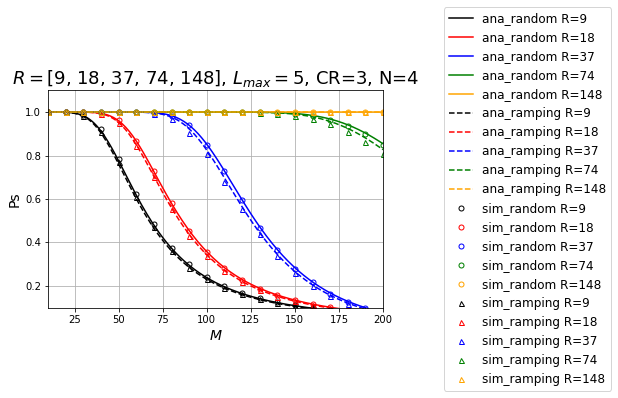

In [25]:
plt.plot(m_list, ps_list_random[0], color='black', label='ana_random R=9')
plt.plot(m_list, ps_list_random[1], color='red', label='ana_random R=18')
plt.plot(m_list, ps_list_random[2], color='blue', label='ana_random R=37')
plt.plot(m_list, ps_list_random[3], color='green', label='ana_random R=74')
plt.plot(m_list, ps_list_random[4], color='orange', label='ana_random R=148')

plt.plot(m_list, ps_list_ramp[0], linestyle = '--', color='black', label='ana_ramping R=9')
plt.plot(m_list, ps_list_ramp[1], linestyle = '--', color='red', label='ana_ramping R=18')
plt.plot(m_list, ps_list_ramp[2], linestyle = '--', color='blue', label='ana_ramping R=37')
plt.plot(m_list, ps_list_ramp[3], linestyle = '--', color='green', label='ana_ramping R=74')
plt.plot(m_list, ps_list_ramp[4], linestyle = '--', color='orange', label='ana_ramping R=148')

plt.plot(m_list_simu, ps_list_simu_9_random, label='sim_random R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, ps_list_simu_18_random, label='sim_random R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, ps_list_simu_37_random, label='sim_random R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, ps_list_simu_74_random, label='sim_random R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, ps_list_simu_148_random, label='sim_random R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.plot(m_list_simu, ps_list_simu_9_ramp, label='sim_ramping R=9', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, ps_list_simu_18_ramp, label='sim_ramping R=18', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, ps_list_simu_37_ramp, label='sim_ramping R=37', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, ps_list_simu_74_ramp, label='sim_ramping R=74', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, ps_list_simu_148_ramp, label='sim_ramping R=148', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR=3, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Ps", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
plt.axis([10,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

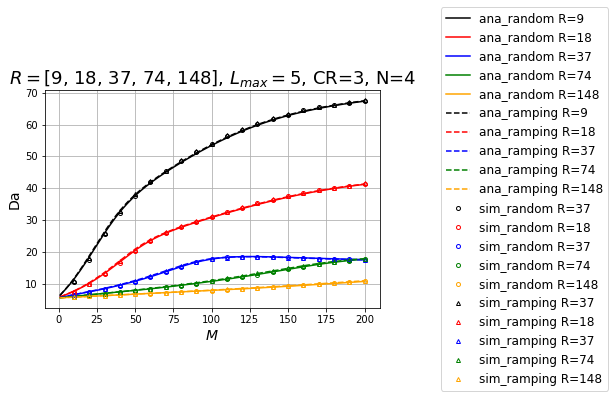

In [26]:
plt.plot(m_list, da_list_random[0], color='black', label='ana_random R=9')
plt.plot(m_list, da_list_random[1], color='red', label='ana_random R=18')
plt.plot(m_list, da_list_random[2], color='blue', label='ana_random R=37')
plt.plot(m_list, da_list_random[3], color='green', label='ana_random R=74')
plt.plot(m_list, da_list_random[4], color='orange', label='ana_random R=148')

plt.plot(m_list, da_list_ramp[0], linestyle = '--', color='black', label='ana_ramping R=9')
plt.plot(m_list, da_list_ramp[1], linestyle = '--', color='red', label='ana_ramping R=18')
plt.plot(m_list, da_list_ramp[2], linestyle = '--', color='blue', label='ana_ramping R=37')
plt.plot(m_list, da_list_ramp[3], linestyle = '--', color='green', label='ana_ramping R=74')
plt.plot(m_list, da_list_ramp[4], linestyle = '--', color='orange', label='ana_ramping R=148')

plt.plot(m_list_simu, da_list_simu_9_random, label='sim_random R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=4)
plt.plot(m_list_simu, da_list_simu_18_random, label='sim_random R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=4)
plt.plot(m_list_simu, da_list_simu_37_random, label='sim_random R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=4)
plt.plot(m_list_simu, da_list_simu_74_random, label='sim_random R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=4)
plt.plot(m_list_simu, da_list_simu_148_random, label='sim_random R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=4)

plt.plot(m_list_simu, da_list_simu_9_ramp, label='sim_ramping R=37', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='black', markersize=4)
plt.plot(m_list_simu, da_list_simu_18_ramp, label='sim_ramping R=18', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='red', markersize=4)
plt.plot(m_list_simu, da_list_simu_37_ramp, label='sim_ramping R=37', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='blue', markersize=4)
plt.plot(m_list_simu, da_list_simu_74_ramp, label='sim_ramping R=74', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='green', markersize=4)
plt.plot(m_list_simu, da_list_simu_148_ramp, label='sim_ramping R=148', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=4)


plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR=3, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Da", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,60]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

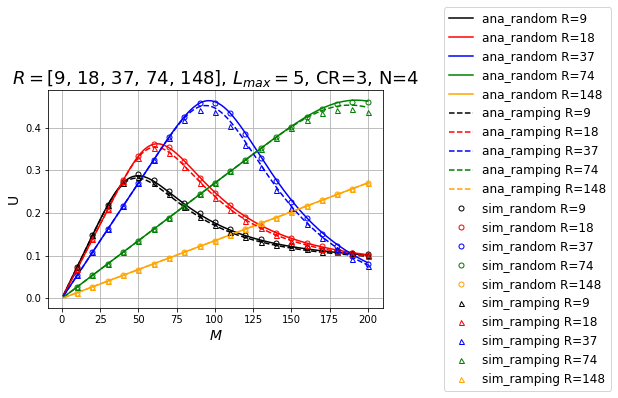

In [27]:
plt.plot(m_list, u_list_random[0], color='black', label='ana_random R=9')
plt.plot(m_list, u_list_random[1], color='red', label='ana_random R=18')
plt.plot(m_list, u_list_random[2], color='blue', label='ana_random R=37')
plt.plot(m_list, u_list_random[3], color='green', label='ana_random R=74')
plt.plot(m_list, u_list_random[4], color='orange', label='ana_random R=148')

plt.plot(m_list, u_list_ramp[0], linestyle = '--', color='black', label='ana_ramping R=9')
plt.plot(m_list, u_list_ramp[1], linestyle = '--', color='red', label='ana_ramping R=18')
plt.plot(m_list, u_list_ramp[2], linestyle = '--', color='blue', label='ana_ramping R=37')
plt.plot(m_list, u_list_ramp[3], linestyle = '--', color='green', label='ana_ramping R=74')
plt.plot(m_list, u_list_ramp[4], linestyle = '--', color='orange', label='ana_ramping R=148')

plt.plot(m_list_simu, u_list_simu_9_random, label='sim_random R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, u_list_simu_18_random, label='sim_random R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, u_list_simu_37_random, label='sim_random R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, u_list_simu_74_random, label='sim_random R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, u_list_simu_148_random, label='sim_random R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.plot(m_list_simu, u_list_simu_9_ramp, label='sim_ramping R=9', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, u_list_simu_18_ramp, label='sim_ramping R=18', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, u_list_simu_37_ramp, label='sim_ramping R=37', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, u_list_simu_74_ramp, label='sim_ramping R=74', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, u_list_simu_148_ramp, label='sim_ramping R=148', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR=3, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("U", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

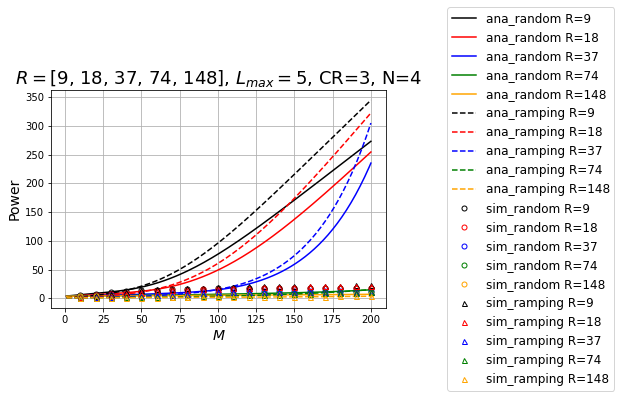

In [28]:
plt.plot(m_list, power_list_random[0], color='black', label='ana_random R=9')
plt.plot(m_list, power_list_random[1], color='red', label='ana_random R=18')
plt.plot(m_list, power_list_random[2], color='blue', label='ana_random R=37')
plt.plot(m_list, power_list_random[3], color='green', label='ana_random R=74')
plt.plot(m_list, power_list_random[4], color='orange', label='ana_random R=148')

plt.plot(m_list, power_list_ramp[0], linestyle = '--', color='black', label='ana_ramping R=9')
plt.plot(m_list, power_list_ramp[1], linestyle = '--', color='red', label='ana_ramping R=18')
plt.plot(m_list, power_list_ramp[2], linestyle = '--', color='blue', label='ana_ramping R=37')
plt.plot(m_list, power_list_ramp[3], linestyle = '--', color='green', label='ana_ramping R=74')
plt.plot(m_list, power_list_ramp[4], linestyle = '--', color='orange', label='ana_ramping R=148')

plt.plot(m_list_simu, power_list_simu_9_random, label='sim_random R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, power_list_simu_18_random, label='sim_random R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, power_list_simu_37_random, label='sim_random R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, power_list_simu_74_random, label='sim_random R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, power_list_simu_148_random, label='sim_random R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.plot(m_list_simu, power_list_simu_9_ramp, label='sim_ramping R=9', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.plot(m_list_simu, power_list_simu_18_ramp, label='sim_ramping R=18', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.plot(m_list_simu, power_list_simu_37_ramp, label='sim_ramping R=37', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.plot(m_list_simu, power_list_simu_74_ramp, label='sim_ramping R=74', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.plot(m_list_simu, power_list_simu_148_ramp, label='sim_ramping R=148', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max}=$' + str(Lmax) + ', CR=3, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Power", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()